In [ ]:
# run in venv3.10 (python3.10.16)
import gc
import os
import logging
import math 
import warnings
import re
import random

# Suppress Python warnings
warnings.filterwarnings("ignore")

# Suppress specific TensorFlow warnings
warnings.filterwarnings('ignore', category=UserWarning, message='.*OUT_OF_RANGE.*')
warnings.filterwarnings('ignore', category=UserWarning, message='.*Local rendezvous recv item cancelled.*')
warnings.filterwarnings('ignore', category=UserWarning, message='.*tensorflow/core.*')

# Optionally, suppress all warnings from TensorFlow
warnings.filterwarnings('ignore', category=UserWarning, module='tensorflow')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from absl import logging as absl_logging
from scipy import stats
from scipy.stats import zscore
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error

import tensorflow as tf

# Suppress TensorFlow logging
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# Suppress Abseil logs
absl_logging.set_verbosity('error')

# Set TensorFlow logging level to only show errors
tf.get_logger().setLevel('ERROR')
tf.config.threading.set_inter_op_parallelism_threads(1)
tf.config.threading.set_intra_op_parallelism_threads(1)

# Redirect TensorFlow logs to a file
logging.basicConfig(filename='tensorflow_logs.txt', level=logging.ERROR)

import tensorflow.keras.backend as K # type: ignore
from tensorflow.keras import layers, Model, optimizers, regularizers    # type: ignore
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau # type: ignore
from tensorflow.keras.models import Sequential                           # type: ignore
from tensorflow.keras.layers import Dense, Dropout, Input, MultiHeadAttention, LayerNormalization   # type: ignore
from tensorflow.keras import backend as K                             # type: ignore


import shap

print(tf.__version__)  # Should print 2.16.2
print(tf.keras.__version__)  # Should print 3.8.0

def interrupt_execution():
    raise KeyboardInterrupt

def add_milliseconds_to_timestamp(df, timestamp_column, milliseconds_column, new_column_name):
    """
    Adds milliseconds to a timestamp column in a Pandas DataFrame.

    Args:
        df: The Pandas DataFrame.
        timestamp_column: The name of the column containing timestamps (datetime objects).
        milliseconds_column: The name of the column containing milliseconds.
        new_column_name: The name of the new column to store the updated timestamps.
    """
    # Convert the timestamp column to datetime objects if they aren't already
    df[timestamp_column] = pd.to_datetime(df[timestamp_column], errors='coerce')

    # Convert milliseconds to Timedelta objects
    df[new_column_name] = df[timestamp_column] + pd.to_timedelta(df[milliseconds_column], unit='s')

    return df

def speed_unit_conversion(df_env, column_name):
    speed_columns = [col for col in df_env.columns if column_name.lower() in col.lower()]
        # print(speed_columns)
        # Extract the measurement unit from the column name
    if speed_columns:
        speed_unit = speed_columns[0].split('(')[-1].split(')')[0]
            # print(f"Wind speed unit: {speed_unit}")
        if speed_columns and speed_unit != 'm/s':
            if speed_unit == 'km/hr' or speed_unit == 'km/h':
                df_env[column_name + ' (m/s)'] = df_env[speed_columns[0]].astype(np.float64) / 3.6
                # print(df_env[column_name + ' (m/s)'].mean())
            elif speed_unit == 'mph':
                df_env[column_name + ' (m/s)'] = df_env[speed_columns[0]].astype(np.float64) / 2.237
                # print(df_env[column_name + ' (m/s)'].mean())
            df_env = df_env.drop(columns=speed_columns[0])
    return df_env

def EItoBeta(EI):
    beta = (1 - EI)*math.pi;
    return beta

def EmotionalIndex(SCL, HR):
    """
    Calculate the Emotional Index (EI) and beta angle based on Skin Conductance Level (SCL) and Heart Rate (HR).

    The function normalizes the SCL and HR values using z-scores, then computes the angle theta using the arctangent
    of the normalized SCL and HR values. The beta angle is derived from theta, and the Emotional Index (EI) is 
    calculated based on the beta angle.

    Parameters:
    SCL (array-like): Skin Conductance Level values.
    HR (array-like): Heart Rate values.

    Returns:
    tuple: A tuple containing:
        - EI (array-like): The Emotional Index values.
        - beta (array-like): The beta angle values.
    """
    SCL = stats.zscore(SCL)
    HR = stats.zscore(HR)
    pi = math.pi
    theta = np.arctan2(SCL, HR)
    beta = pi/2 - theta
    i = np.logical_and(SCL >= 0, HR <= 0)
    beta[i] = (2.5*pi) - theta[i]
    EI = 1 - beta/pi
    return EI, beta

def pearson_correlation(y_true, y_pred):
    # Cast both to float32 to ensure compatibility
    # y_true - tf.cast(y_true, tf.float64)
    # y_pred - tf.cast(y_pred, tf.float64)
    y_true = tf.convert_to_tensor(y_true, dtype=tf.float32)
    y_pred = tf.convert_to_tensor(y_pred, dtype=tf.float32)
    # Compute the mean of true and predicted values
    y_true_mean = K.mean(y_true) 
    y_pred_mean = K.mean(y_pred)
    # Center the data by subtracting the mean
    y_true_centered = y_true - y_true_mean
    y_pred_centered = y_pred - y_pred_mean
    # Compute the numerator: covariance between _true and y_pred
    covariance = K.sum(y_true_centered * y_pred_centered)
    # Compute the denominator: product-of standard deviations
    y_true_std = K.sqrt(K.sum(K.square(y_true_centered)))
    y_pred_std = K.sqrt(K.sum(K.square(y_pred_centered)))
    # To avoid division by zero, add a small epsilon
    epsilon = K.epsilon()
    # Pearson correlation coefficient
    correlation = covariance / (y_true_std * y_pred_std + epsilon)
    # Return the correlation as a positive metric (optional: map to [O, 1] scale)
    return correlation

def importTimestampsDataFrame(file):
    timestamps = pd.read_csv(file)
    ids = timestamps['Row'].to_numpy()
    timestamps = timestamps.drop('Row', axis = 1)
    for val in timestamps.columns:
        timestamps[val] = pd.to_datetime(timestamps[val])
    timestamps.index = ids
    return timestamps

def importTimestamps(file):
    """
    Import timestamps for subject phases from a CSV file and prepare them for the data generator.

    Parameters:
        file (str): Path to the CSV file containing phase timestamps.
    
    Returns:
        dict: Dictionary where keys are subject IDs and values are lists of (start_time, end_time) tuples for each phase.
    """
    # Read the CSV file
    timestamps = pd.read_csv(file)
    
    # Extract the subject IDs from the 'Row' column
    ids = timestamps['Row'].to_numpy()
    
    # Drop the 'Row' column to process phase timestamps
    timestamps = timestamps.drop('Row', axis=1)
    
    # Convert all columns to datetime format
    for val in timestamps.columns:
        timestamps[val] = pd.to_datetime(timestamps[val])
    
    # Initialize the output dictionary
    phase_dict = {}
    
    # Process each subject's data
    for idx, subject_id in enumerate(ids):

        subject_id = subject_id.replace("Bicocca", "").lstrip("0")
        # Extract the row corresponding to the subject
        phase_times = timestamps.iloc[idx].dropna().to_list()  # Convert non-NaN values to a list
        
        # Create (start_time, end_time) tuples for consecutive pairs of timestamps
        phase_intervals = [(phase_times[i], phase_times[i + 1]) for i in range(len(phase_times) - 1)]
        
        # Store the phase intervals in the dictionary
        phase_dict[subject_id] = phase_intervals
    
    return phase_dict

def reconstruction(autoencoder, data, vars_to_use, scaler = 'none'):

    input_dim = data.shape[1]
    reconstructed_data = autoencoder.predict(data)
    if scaler != 'none':
        reconstructed_data = scaler.inverse_transform(reconstructed_data)


    # Convert the reconstructed data to a DataFrame
    reconstructed_df = pd.DataFrame(reconstructed_data, columns=vars_to_use)

    # Calculate the Pearson correlation between the original and reconstructed data
    correlation = np.array([0.0] * input_dim)
    for n in range(0, input_dim):
        correlation[n] = pearson_correlation(data[:, n], reconstructed_data[:, n])
        if correlation[n] > 0:
            print(f'{vars_to_use[n]:<32}:  {correlation[n]:.2f}')
        else:
            print(f'{vars_to_use[n]:<32}: {correlation[n]:.2f}')
    mean_correlation = np.mean(correlation)
    if mean_correlation >0:
        print(f'\n{"Mean correlation:":<32}:  {mean_correlation:.2f}')
    else:
        print(f'\n{"Mean correlation:":<32}: {mean_correlation:.2f}')
    return reconstructed_df

def split_feature_unit(feature):
    match = re.match(r"(.+?)\s*\((.+)\)", feature)
    if match:
        feature_name = match.group(1).strip()
        unit = "[" + match.group(2).strip().replace("micro", "\u03BC") + "]"

    else:
        feature_name = feature.strip()
        unit = None  # No unit found
    
    return feature_name, unit

def randomSubjectEvaluation(autoencoder, optimizer='RMSprop', filename = 'autoencoder', unwrap = False, ID = 'Random'):
    global data_tot, vars_to_use, rolling_window_size, scaler, resample, timestamps_df
    i = 0
    print("Optimizer: ", optimizer)
    # Select a random subject from data_tot
    
    while True:
            
        i += 1
        if i == 10:
            return
        if ID == 'Random':
            random_subject_id = random.choice(list(data_tot.keys()))
        else:
            random_subject_id = ID
        random_subject_data = data_tot[random_subject_id]           
        if resample > 0:
            random_subject_data = random_subject_data.resample(str(resample) + 's', on='Timestamp').mean(numeric_only=True).reset_index()
        t = random_subject_data['Timestamp']
        if rolling_window_size > 1:
            random_subject_data = random_subject_data.rolling(window=rolling_window_size, min_periods=1).mean(numeric_only=True)
        random_subject_data = random_subject_data[vars_to_use]
        if unwrap:
            beta_columns = [col for col in random_subject_data.columns if 'beta' in col.lower()]
            for beta_col in beta_columns:
                random_subject_data[beta_col] = np.unwrap(random_subject_data[beta_col])
        if scaler != 'None':
            random_subject_data = pd.DataFrame(scaler.transform(random_subject_data), columns= vars_to_use)
        
        try:
            # Predict the data using the autoencoder
            predicted_data = pd.DataFrame(autoencoder.predict(random_subject_data), columns=vars_to_use)
            break  # Exit the loop if prediction is successful
        except (ValueError, tf.errors.InvalidArgumentError, OverflowError, ZeroDivisionError):
            if ID == 'Random':
                print(f"Prediction failed for subject ID: {random_subject_id}. Retrying with a new subject ID.")
                continue
            else:
                print(f"Prediction failed for subject ID: {random_subject_id}. Retry with a new subject ID.")
                return()


    corr = {}
    reconstruction_error = {}
    for feature in vars_to_use:
        reconstruction_error[feature] = mean_absolute_error(random_subject_data[feature], predicted_data[feature])
        corr[feature] = pearson_correlation(random_subject_data[feature], predicted_data[feature])

    if scaler != 'None':
        predicted_data = pd.DataFrame(scaler.inverse_transform(predicted_data), columns= vars_to_use)
        random_subject_data = pd.DataFrame(scaler.inverse_transform(random_subject_data), columns=vars_to_use)
        # predicted_data = scaler.inverse_transform(predicted_data_scaled)
        # random_subject_data = pd.DataFrame(scaler.inverse_transform(random_subject_data), columns=vars_to_use)
    
    # Ensure the number of columns in predicted_data matches vars_to_use
    if predicted_data.shape[1] != len(vars_to_use):
        raise ValueError(f"Shape of predicted_data is {predicted_data.shape}, but expected {len(vars_to_use)} columns.")

    # Convert the predicted data to a DataFrame
    predicted_df = pd.DataFrame(predicted_data, columns=vars_to_use)

    # Plot the real vs predicted data for each variable
    num_features = len(vars_to_use)
    fig, axes = plt.subplots(num_features, 1, figsize=(12, 2 * num_features), sharex=True)
    # fig.patch.set_alpha(0.0)  # Set figure background to transparent
    # axes.patch.set_alpha(0.0)   # Set axes background to transparent
    
    # Get the timestamps for the subject from timestamps_df
    subject_timestamps = timestamps_df.loc['Bicocca' + random_subject_id]

    for i, feature in enumerate(vars_to_use):
        real_data = random_subject_data[feature].values
        predicted_data = predicted_df[feature].values
        feature_name, unit = split_feature_unit(feature)
        # Ensure that the data is within valid range for plotting
        real_data = np.nan_to_num(real_data, nan=0.0, posinf=0.0, neginf=0.0)
        predicted_data = np.nan_to_num(predicted_data, nan=0.0, posinf=0.0, neginf=0.0)
        
        # Compute z-scores
        # real_data_zscore = zscore(real_data)
        # scale predicted data so that it has the same mean and variance as the real data
        predicted_data = zscore(predicted_data) * np.std(real_data) + np.mean(real_data)
        
        axes[i].plot(t, real_data, label='Actual Data', color='blue', alpha=0.7)
        axes[i].plot(t, predicted_data, label='Reconstructed Data', color='red', alpha=0.7)
        # plot vertical lines separating the phases
        for l in range(len(subject_timestamps) - 1):
        
            axes[i].axvline(x=subject_timestamps.iloc[l], color='gray', linestyle='--', alpha=0.5, label = None)
            # if l is even, shade the area between the current and the next vertical line
            if l % 2 == 0:
                axes[i].axvspan(subject_timestamps.iloc[l], subject_timestamps.iloc[l+1], color='gray', alpha=0.1, label = None)
        # plot the reconstruction error
        # axes[i].plot(np.abs(real_data - predicted_data), label='Reconstruction Error', color='green', alpha=0.7, linestyle='--')
        axes[i].set_title(f'{feature_name} - Correlation: {corr[feature]:.2f}')
        axes[i].set_xlabel('Protocol Phase')
        axes[i].set_ylabel(unit)
        axes[i].legend(loc='center left', bbox_to_anchor=(1, 0.5))
        axes[i].grid(True)
        # set the xlim from 0 to the end of the time series
        axes[i].set_xlim(subject_timestamps.iloc[0], subject_timestamps.iloc[-1])
        # show the xticks labels
        axes[i].set_xticks(subject_timestamps)
        xlabels = timestamps_df.columns
        # xlabels = [f'{x*10/360:.0f}' for x in xpositions]
        # axes[i].set_xticks(xpositions)
        axes[i].set_xticklabels(xlabels, rotation=30, rotation_mode = 'anchor', ha = 'right')
        # Adjust the bottom margin to prevent label truncation
        fig.subplots_adjust(hspace = .6)

    corr = pd.DataFrame(corr, index = pd.Index(['Bicocca' + random_subject_id]), columns=vars_to_use)
    reconstruction_error = pd.DataFrame(reconstruction_error, index = pd.Index(['Bicocca' + random_subject_id]), columns=vars_to_use)
    # set the title of the figure as the random subject ID
    fig.suptitle(f'Actual vs Reconstructed Data, Subject ID: {random_subject_id}', fontsize=16)
    print(f"Random subject ID: {random_subject_id}")
    print(f'Mean correlation: {np.mean(corr):.2f}')
    fig.tight_layout()
    # fig.show()
    plt.show()
    os.makedirs('RECONSTRUCTION', exist_ok=True)
    fig.savefig(f'RECONSTRUCTION/Bicocca{random_subject_id}_{filename}.svg', transparent=True, bbox_inches='tight', pad_inches=0)
    fig.savefig(f'RECONSTRUCTION/Bicocca{random_subject_id}_{filename}.png', dpi = 250, transparent=True, bbox_inches='tight', pad_inches=0)
    return reconstruction_error, corr

# Function to output memory usage
def memory_usage():
    import psutil
    # Print the memory usage in MB
    mem = psutil.Process(os.getpid()).memory_info().rss / 1024 ** 2
    return mem

def subject_data_generator(subject_dict, rolling_window_size=15, vars_to_use = ['All'], scaler = 'None', resample = 0):
    if vars_to_use[0] == 'All':
        vars_to_use = list(subject_dict.values())[0].columns
    for subject_id, subject_data in subject_dict.items():
        if subject_data.shape[0] == 0:
            continue
        if resample > 0:
            subject_data.resample(str(resample) + 's', on='Timestamp').mean(numeric_only=True).reset_index()
        subject_data = subject_data[vars_to_use]
        # Smooth the time series with a rolling window
        subject_data = subject_data.rolling(window=rolling_window_size, min_periods=1).mean()
        if not subject_data.empty and scaler != 'None':
            subject_data.value = scaler.transform(subject_data)
        # Assuming subject_data is a DataFrame and we are using its values as input/output
        yield subject_data.value, subject_data.value  # Autoencoders use input = output

def segment_data_generator(subject_dict, phase_timestamps, rolling_window_size=15, vars_to_use=['All'], scaler=None, resample=0):
    """
    Generate batches corresponding to one phase from one subject.
    
    Parameters:
        subject_dict (dict): Dictionary where keys are subject IDs and values are DataFrames containing subject data.
        phase_timestamps (dict): Dictionary where keys are subject IDs and values are lists of tuples (start_time, end_time) for each phase.
        rolling_window_size (int): Size of the rolling window for smoothing the time series.
        vars_to_use (list): Variables to include in the batch. Use ['All'] to include all variables.
        scaler (object): Scaler object (e.g., MinMaxScaler) to apply to the data. Use `None` for no scaling.
        resample (int): Resampling interval in seconds. Use 0 for no resampling.

    Yields:
        tuple: A batch (X, Y) where both X and Y are numpy arrays for the input and output of the autoencoder.
    """
    if vars_to_use[0] == 'All':
        vars_to_use = list(subject_dict.values())[0].columns
    
    for subject_id, subject_data in subject_dict.items():
        # Skip empty data
        if subject_data.shape[0] == 0:
            continue
        
        # if subject_id contains 'Bicocca', remove it
        subject_id = subject_id.replace("Bicocca", "").lstrip("0")
        
        # If there are missing variables, skip the subject
        if not set(vars_to_use).issubset(subject_data.columns):
            continue

        # Get phase timestamps for this subject
        subject_phases = phase_timestamps.get(subject_id, [])
        if not subject_phases:
            continue  # Skip if no phase timestamps are available for the subject
        
        for phase_start, phase_end in subject_phases:
            # memory_usage()
            # Extract the data corresponding to the phase
            phase_data = subject_data[(subject_data['Timestamp'] >= phase_start) & (subject_data['Timestamp'] <= phase_end)]
            if phase_data.empty:
                continue  # Skip empty phases

            # Resample the data if requested
            if resample > 0:
                phase_data = phase_data.resample(str(resample) + 's', on='Timestamp').mean(numeric_only=True).reset_index()

            # Select the specified variables
            phase_data = phase_data[vars_to_use]

            # Smooth the time series with a rolling window
            phase_data = phase_data.rolling(window=rolling_window_size, min_periods=1).mean()

            # Apply scaling if a scaler is provided
            if not phase_data.empty and scaler is not None:
                phase_data[vars_to_use] = scaler.transform(phase_data[vars_to_use])

            # get the variable in vars_to_use that contain the work 'beta' with any capitalizatio
            beta_columns = [col for col in phase_data.columns if 'beta' in col.lower()]
            # unwrap the beta columns with the np.unwrap function
            for beta_col in beta_columns:
                phase_data[beta_col] = np.unwrap(phase_data[beta_col])

            # globals_to_delete = [var for var, val in globals().items() if isinstance(val, pd.DataFrame) and var != 'phase_data']

            # for var in globals_to_delete:
            #     del globals()[var]
             
            locals_to_delete = [var for var, val in locals().items() if isinstance(val, pd.DataFrame) and var != 'phase_data']

            for var in locals_to_delete:
                del locals()[var]

            # Yield the batch (input = output for autoencoders)
            yield phase_data.values, phase_data.values


def cleanup(keep_vars = ['data_tot', 'timestamps_df', 'vars_to_use', 'df_tot']):
    # clear up the workspace:
    # delete everything except the following variables:
    # data_tot, timestamps, vars_to_use, df_tot
    # delete everything else
    
    # Filter the global namespace and delete everything else
    globals_to_delete = [var for var, val in globals().items() if isinstance(val, pd.DataFrame) and var not in keep_vars]

    mem = memory_usage()
    for var in globals_to_delete:
        del globals()[var]

    try:
        K.clear_session()
        del autoencoder
        del encoder
        del decoder
    except:
        pass
    gc.collect()
    print(f"Memory usage after cleanup: {memory_usage():.2f} MB (freed up {mem - memory_usage():.2f} MB)")
    
def prepare_data_for_shap(generator, max_samples=None):
    """
    Prepare scaled and resampled data for SHAP analysis using segment_data_generator.
    
    Parameters:
        subject_dict (dict): Dictionary where keys are subject IDs and values are DataFrames containing subject data.
        phase_timestamps (dict): Dictionary where keys are subject IDs and values are lists of tuples (start_time, end_time) for each phase.
        rolling_window_size (int): Size of the rolling window for smoothing the time series.
        vars_to_use (list): Variables to include in the batch. Use ['All'] to include all variables.
        scaler (object): Scaler object (e.g., MinMaxScaler) to apply to the data. Use `None` for no scaling.
        resample (int): Resampling interval in seconds. Use 0 for no resampling.
        max_samples (int): Maximum number of samples to include for SHAP analysis.
        
    Returns:
        np.ndarray: Scaled and resampled data prepared for SHAP analysis.
    """

    # if max_samples is None, use all samples
    # if max_samples is None:
    #     max_samples = len(subject_dict) * len(phase_timestamps)  # Maximum possible samples
    #     print(max_samples)
    data_for_shap = []

    # Use the segment_data_generator to process the data
    # generator = segment_data_generator(subject_dict, 
    #                                    phase_timestamps, 
    #                                    rolling_window_size=rolling_window_size, 
    #                                    vars_to_use=vars_to_use, 
    #                                    scaler=scaler, 
    #                                    resample=resample)

    
    for batch_x, _ in generator:
        if max_samples is not None and len(data_for_shap) + len(batch_x) > max_samples:
            # Stop adding samples if we've reached the max_samples limit
            remaining_samples = max_samples - len(data_for_shap)
            data_for_shap.extend(batch_x[:remaining_samples])
            break
        
        # Add the batch to the data list
        data_for_shap.extend(batch_x)

    # Convert the collected data to a NumPy array
    data_for_shap = np.array(data_for_shap)
    
    return data_for_shap

def neg_pearson_correlation(y_true, y_pred):
    x = y_true - K.mean(y_true, axis=0)
    y = y_pred - K.mean(y_pred, axis=0)
    numerator = K.sum(x * y, axis=0)
    denominator = K.sqrt(K.sum(K.square(x), axis=0)) * K.sqrt(K.sum(K.square(y), axis=0))
    pearson_corr = numerator / (denominator + K.epsilon())
    return -K.mean(pearson_corr)

def SHAP(autoencoder, generator, filename = 'autoencoder', feature_names = None):
    # Define parameters for data preparation
    max_samples = 100  # Limit the number of samples for SHAP

    # if feature_names is None, use all features in generator
    
    # Call the function to prepare the data
    shap_data = prepare_data_for_shap(generator = generator,
                                    max_samples=max_samples)
    print(shap_data.shape)
    # Use the data with SHAP
    explainer = shap.GradientExplainer(autoencoder, shap_data)
    shap_values = explainer.shap_values(shap_data)

    

    # Generate a SHAP summary plot
    # create a new figure
    # fig, ax = plt.subplots(figsize=(16, 10))    
# Adjust margins to prevent cropping
    # shap.plots.beeswarm(shap_values)
    shap.summary_plot(shap_values, shap_data, feature_names=feature_names, plot_size=(16, 5), show = False)
    fig = plt.gcf()
    fig.patch.set_alpha(0.0)  # Set figure background to transparent
    ax = plt.gca()
    ax.patch.set_alpha(0.0)   # Set axes background to transparent
    fig.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)

# Adjust margins to prevent cropping
    
    os.makedirs('SHAP', exist_ok=True)
    fig.savefig(f'SHAP/{filename}.svg', bbox_inches='tight')
# check the environment: if windows, set the path to the datasets
if os.name == 'nt':
    path_physio = "F:/OneDrive - Politecnico di Milano/PhD/MUSA/bicocca/DATA/PHYSIO_FOR_ENCODER"
    # change the \ to / 
    path_physio = path_physio.replace('\\', '/')
    # remove the spaces
    # path_physio = path_physio.replace(' ', '')
else:
    path_physio = "/Users/chiaramaninetti/Library/CloudStorage/OneDrive-PolitecnicodiMilano/PhD/MUSA/bicocca/DATA/PHYSIO_FOR_ENCODER"
# print the GPU in use
print("TensorFlow version: ", tf.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("Num CPUs Available: ", len(tf.config.experimental.list_physical_devices('CPU')))



In [ ]:
# IMPORT THE DATA

timestamps = importTimestamps(path_physio + '/timestamps.csv')
timestamps_df = importTimestampsDataFrame(path_physio + '/timestamps.csv')

df_tot = pd.DataFrame()
data_tot = {}

for i in range(1, 70):
    if i < 10:
        id = "0" + str(i)
    else:
        id = str(i)
    file_physio = os.path.join(path_physio, "Bicocca" + id + ".csv")

    try:
        if not os.path.exists(file_physio):
            interrupt_execution()

        try:
            df_physio = pd.read_csv(file_physio)
            # linearly interpolate the missing values
            df_physio = df_physio.interpolate(method='linear', limit_direction='both')
            df_physio = add_milliseconds_to_timestamp(df_physio, 'Recording start', 'Time since start (s)', 'Timestamp')   
        except:
            interrupt_execution() 
        # Replace ',' with '.' in all string columns of df_physio
        df_physio = df_physio.map(lambda x: x.replace(',', '.') if isinstance(x, str) else x)
        # df_physio['Beta Angle (rad)'] = 
        df_tot = pd.concat([df_tot, df_physio], ignore_index=True)
        data_tot[id] = df_physio

    except KeyboardInterrupt:
        if not os.path.exists(file_physio):
            print(f'File "Bicocca{id}.csv" not found in physiological dataset.')
        else:
            print(f'Error reading data for Bicocca{id}.')


In [ ]:
# DEFINE THE VARIABLES TO USE

to_rem = [
            'Phasic Skin Conductance (a.u.)',
            'Tonic Skin Conductance (a.u.)',
            # 'Skin Conductance (microS)',
            'Skin Conductance Phasic Driver (a.u.)',
            'ID', 'Recording start', 'Time since start (s)', 
            'Beta Angle (rad)',
            'Low Frequency Power (s^2/Hz)', 
            'High Frequency Power (s^2/Hz)',
            # 'Respiratory Frequency (cycles/minute)'
        ]
vars = df_tot.columns
vars_to_use = vars.drop(to_rem)
vars_to_use = vars_to_use.drop('Timestamp')
# Define variables
vars_to_use = pd.Index(vars_to_use)


print(vars_to_use)


In [ ]:
# REMOVE VARIABLES THAT AREN'T RELEVANT AND CLEAN UP THE WORKSPACE
# 'Timestamp', 'Satellite Count', 'Latitude (°)', 'Longitude (°)', 'Altitude (m)', 'Time since start (s)'
# remove from data_tot the ids that are saved into id_to_rem
id_to_rem = []
for id in data_tot.keys():
    #if they exist, drop the columns
    # if the number of columns in data_tot[id] is less than the lengh of vars, remove the id from the dictionary
    if len(data_tot[id].columns) < len(vars):
        id_to_rem.append(id)
        continue
    data_tot[id] = data_tot[id][vars]

    for var in to_rem:
        if var in data_tot[id].columns:
            data_tot[id] = data_tot[id].drop(columns=[var])
            
# for id in id_to_rem:
#     data_tot.pop(id)
    
# scaler = MinMaxScaler()
# # print(df_tot_2.columns)
# scaler.fit(df_tot_2.drop('Timestamp', axis=1))

# df_tot_2_scaled = scaler.transform(df_tot_2)
# df_tot_2_scaled = pd.DataFrame(df_tot_2_scaled, columns=df_tot_2.columns)

for id in data_tot.keys():
    # scaler.fit(data_tot[id])
    # data_tot[id] = data_tot[id][vars]
    # data_tot[id] = scaler.transform(data_tot[id])
    data_tot[id] = pd.DataFrame(data_tot[id], columns=np.setdiff1d(vars, to_rem))
    data_tot[id] = data_tot[id].dropna()

cleanup()

In [ ]:
# MODEL # 3 - AUTOENCODER WITH ATTENTION LAYER - SUBJECTS AS BATCHES
# use each subject's data as a batch
# try smoothing the data with a rolling window of n seconds, and downsampling
# try using different alternative optmizers
# include attention layer

from tensorflow.keras.losses import Huber # type: ignore

by_segment = True
attention = True
neurons = 16
dropout_factor = 0.1

rolling_window_size = 5
resample = 2.5

data = df_tot.resample(str(resample) + 's', on='Timestamp').mean(numeric_only=True).reset_index()[vars_to_use].dropna().values
# data = df.values  # Convert DataFrame to numpy array
scaler = MinMaxScaler().fit(data)

# Define the model
input_layer = Input(shape=(len(vars_to_use),))

# Encoder part
x = Dense(neurons * 4, activation='relu')(input_layer)
x = Dropout(dropout_factor)(x)
x = Dense(neurons * 2, activation='relu')(x)
x = Dropout(dropout_factor)(x)
x = Dense(neurons, activation='relu')(x)
x = Dropout(dropout_factor)(x)



if attention:

    # Custom layer to expand dimensions
    class ExpandDimsLayer(tf.keras.layers.Layer):
        def __init__(self, axis, **kwargs):
            super(ExpandDimsLayer, self).__init__(**kwargs)
            self.axis = axis

        def call(self, inputs):
            return tf.expand_dims(inputs, axis=self.axis)

    # Custom layer to squeeze dimensions
    class SqueezeDimsLayer(tf.keras.layers.Layer):
        def __init__(self, axis, **kwargs):
            super(SqueezeDimsLayer, self).__init__(**kwargs)
            self.axis = axis

        def call(self, inputs):
            return tf.squeeze(inputs, axis=self.axis)

    # Expand dimensions to add sequence length dimension
    x_expanded = ExpandDimsLayer(axis=1)(x)
    
    # Attention layer
    attention_output = MultiHeadAttention(num_heads=4, key_dim=neurons)(x_expanded, x_expanded)
    attention_output = SqueezeDimsLayer(axis=1)(attention_output)  # Remove the sequence length dimension
    x = LayerNormalization()(attention_output + x)  # Residual connection and normalization

x = Dense(neurons, activation='relu')(x)
x = Dropout(dropout_factor)(x)

x = Dense(2*neurons, activation='relu')(x)
x = Dropout(dropout_factor)(x)

x = Dense(4*neurons, activation='relu')(x)
x = Dropout(dropout_factor)(x)

# Decoder part
output_layer = Dense(len(vars_to_use), activation='sigmoid')(x)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=4, restore_best_weights=True)

# Alternative optimizers
# optimizers = {
#     'SGD': tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9),
#     'RMSprop': tf.keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9),
#     'Adagrad': tf.keras.optimizers.Adagrad(learning_rate=0.01),
#     'Adadelta': tf.keras.optimizers.Adadelta(learning_rate=1.0, rho=0.95),
#     'Nadam': tf.keras.optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999), 
#     'Adam': tf.keras.optimizers.Adam(learning_rate=0.001)
# }

tot_segments = 0
for batch in segment_data_generator(data_tot, 
                            phase_timestamps=timestamps, 
                            rolling_window_size=rolling_window_size, 
                            vars_to_use=vars_to_use, 
                            scaler=scaler, 
                            resample=resample):
    tot_segments += 1
# 
optimizers = {'Adam': tf.keras.optimizers.Adam(learning_rate=0.001)
              }
# with tf.device('/GPU:0'):
for optimizer in optimizers.keys():
# Choose an optimizer
    chosen_optimizer = optimizers[optimizer]
    print("USING OPTIMIZER", optimizer)
    autoencoder = Model(inputs=input_layer, outputs=output_layer)
    autoencoder.compile(optimizer=chosen_optimizer, loss=neg_pearson_correlation)

    if by_segment:
        # Each batch is a single procotol segment from a single subject
        generator = segment_data_generator(data_tot, 
                            phase_timestamps=timestamps, 
                            rolling_window_size=rolling_window_size, 
                            vars_to_use=vars_to_use, 
                            scaler=scaler, 
                            resample=resample)
        # the steps per epoch is the number of batches
        steps_per_epoch = tot_segments
        unwrap = True
    else:
        # Each batch is a whole protocol recording from a single subject
        generator = subject_data_generator(data_tot, 
                                        rolling_window_size = rolling_window_size, 
                                        vars_to_use = vars_to_use, 
                                        scaler = scaler, 
                                        resample = resample)
        steps_per_epoch = len(data_tot)
        unwrap = False
    
    
    autoencoder.fit(generator, steps_per_epoch=steps_per_epoch, epochs=25, verbose=1, callbacks=[early_stopping])

    
    name = "encoder_model_3" + optimizer + ("_attention" if attention else "") + ("_by_subject" if not by_segment else "_by_segment")
    randomSubjectEvaluation(autoencoder, 
                            optimizer = optimizer, 
                            filename = name,
                            unwrap = unwrap)
    os.makedirs('MODELS', exist_ok=True)
    autoencoder.save('MODELS/' + name + ".keras")
        
    # if by_segment:
    #         # Each batch is a single procotol segment from a single subject
    #         generator = segment_data_generator( data_tot, 
    #                                             phase_timestamps=timestamps, 
    #                                             rolling_window_size=rolling_window_size, 
    #                                             vars_to_use=vars_to_use, 
    #                                             scaler=scaler, 
    #                                             resample=resample)
    #         # the steps per epoch is the number of batches
    #         steps_per_epoch = tot_segments
    # else:
    #         # Each batch is a whole protocol recording from a single subject
    #         generator = subject_data_generator( data_tot, 
    #                                             rolling_window_size = rolling_window_size, 
    #                                             vars_to_use = vars_to_use, 
    #                                             scaler = scaler, 
    #                                              resample = resample)
    #         steps_per_epoch = len(data_tot)
    # SHAP(autoencoder, generator, name, vars_to_use)


In [ ]:
# EVALUATE EACH SUBJECT: PLOT RECONSTRUCTION VS ORIGINAL DATA, COMPUTE CORRELATION AND MAE
# import the model 'encoder_model_3Adam_attention_by_segment.keras'
# evaluate the model on each subject
# plot the reconstruction vs original data
data = df_tot.resample(str(resample) + 's', on='Timestamp').mean(numeric_only=True).reset_index()[vars_to_use].dropna().values
# data = df.values  # Convert DataFrame to numpy array
scaler = MinMaxScaler().fit(data)
from tensorflow.keras.saving import register_keras_serializable # type: ignore
load_prev = True
if load_prev:
    # Register custom layers
    @register_keras_serializable()
    class ExpandDimsLayer(tf.keras.layers.Layer):
        def __init__(self, axis, **kwargs):
            super(ExpandDimsLayer, self).__init__(**kwargs)
            self.axis = axis

        def call(self, inputs):
            return tf.expand_dims(inputs, axis=self.axis)

    @register_keras_serializable()
    class SqueezeDimsLayer(tf.keras.layers.Layer):
        def __init__(self, axis, **kwargs):
            super(SqueezeDimsLayer, self).__init__(**kwargs)
            self.axis = axis

        def call(self, inputs):
            return tf.squeeze(inputs, axis=self.axis)

    # Load the model
    autoencoder = tf.keras.models.load_model('/Users/chiaramaninetti/Library/CloudStorage/OneDrive-PolitecnicodiMilano/PhD/MUSA/python/MODELS/encoder_model_3Adam_attention_by_segment_good.keras', 
                                            compile=False, custom_objects={'ExpandDimsLayer': ExpandDimsLayer, 'SqueezeDimsLayer': SqueezeDimsLayer})

ids = list(data_tot.keys())
subject_errors = pd.DataFrame(columns=vars_to_use)
pearson_correlations = pd.DataFrame(columns=vars_to_use)
for ID in ids:
    with tf.device('/GPU:0'):
        error, corr = randomSubjectEvaluation(autoencoder, 
                                    optimizer = optimizer, 
                                    filename = name,
                                    unwrap = unwrap, 
                                    ID = ID)
        subject_errors = pd.concat([subject_errors, error])
        pearson_correlations = pd.concat([pearson_correlations, corr])
    # break
    gc.collect()
# subject_errors = pd.DataFrame.from_dict(subject_errors, orient='index', columns=vars_to_use)
# pearson_correlations = pd.DataFrame.from_dict(pearson_correlations, orient='index', columns=vars_to_use)
# df_errors = pd.DataFrame.from_dict(subject_errors, orient='index', columns=['Reconstruction_Error'])
# print(df_errors)

In [9]:
# IDENTIFY OUTLIERS
subject_errors['Mean'] = subject_errors.mean(axis=1)
pearson_correlations = abs(pearson_correlations.astype(float))
pearson_correlations['Mean'] = pearson_correlations.mean(axis=1)
outliers_mae = pd.DataFrame(columns=vars_to_use)
outliers_corr = pd.DataFrame(columns=vars_to_use)
thresholds_mae = {}
thresholds_corr = {}
for var in subject_errors.columns:  
    thresholds_mae[var] = subject_errors[var].mean() + 2 * subject_errors[var].std()
    thresholds_corr[var] = pearson_correlations[var].mean() - 2 * pearson_correlations[var].std()
    if thresholds_corr[var] < .5:
        thresholds_corr[var] = .5
    # if thresholds_mae[var] > .1:
    #     thresholds_mae[var] = .1
    outliers_mae[var] = subject_errors[var] > thresholds_mae[var]
    outliers_corr[var] = pearson_correlations[var] < thresholds_corr[var]

In [ ]:
# plot a heatmap of the reconstruction errors
plt.figure(figsize=(16, 16))
sns.heatmap(subject_errors, annot=True, fmt=".3f", cmap='RdYlGn_r', center=0.05)
plt.title('Reconstruction Errors for Each Subject')
plt.xlabel('Variables')
plt.ylabel('Subject ID')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# plot a heatmap of the Pearson correlations
plt.figure(figsize=(16, 16))
sns.heatmap(pearson_correlations, annot=True, fmt=".3f", cmap='RdYlGn', center=0.5)
plt.title('Pearson Correlations for Each Subject')
plt.xlabel('Variables')
plt.ylabel('Subject ID')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
# print the mean Pearson correlation per variable
print(pearson_correlations.median())
pearson_correlations.describe()

In [ ]:
for var in vars_to_use:
    print(f'\nVariable: {var}\n')
    print(pearson_correlations.groupby('Cluster').describe()[var])

In [ ]:
# CLUSTERIZE THE SUBJECTS BASED ON THE PEARSON CORRELATION BETWEEN REAL AND RECONSTRUCTED DATA

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import plotly.graph_objects as go
import plotly.express as px
import plotly.colors as pc

# Extract the mean Pearson correlation values for clustering
correlation_data = pearson_correlations.drop('Mean', axis=1).values

# Standardize the data
scaler = StandardScaler()
correlation_data_scaled = scaler.fit_transform(correlation_data)
print(vars_to_use)
# Perform KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=42, n_init='auto')  # Explicitly set n_init
pearson_clusters = kmeans.fit_predict(correlation_data_scaled)
pearson_clusters = pd.DataFrame(pearson_clusters, index=pearson_correlations.index, columns=['Cluster'])
# print the number of subjects in each cluster
print(pearson_clusters['Cluster'].value_counts())

# Add the cluster labels to the dataframe
pearson_correlations['Cluster'] = pearson_clusters

# Define the colorscale to match the scatter plot
colorscale = 'Plasma'

if len(vars_to_use) > 2:
    marker_size = pearson_correlations[vars_to_use[0]] * 50
    x_points=pearson_correlations[vars_to_use[1]],
    y_points=pearson_correlations[vars_to_use[3]],
    z_points=pearson_correlations[vars_to_use[2]]
else:
    x_points=pearson_correlations[vars_to_use[1]],
    y_points=pearson_correlations[vars_to_use[3]],
    z_points=pearson_correlations[vars_to_use[2]],
    marker_size = 10
# Create the figure and add the main scatter plot (hidden from legend)
fig = go.Figure(
    data=[go.Scatter3d(
        x=pearson_correlations[vars_to_use[1]],
        y=pearson_correlations[vars_to_use[3]],
        z=pearson_correlations[vars_to_use[2]],
        mode='markers',
        marker=dict(
            size=marker_size,
            color=pearson_correlations['Cluster'],  # Use cluster labels for color
            colorscale=colorscale,  # Ensure consistency
            opacity=1
        ), 
        text=pearson_correlations.index,  # Display Bicocca ID on hover
        showlegend=False  # Hide this trace from the legend
    )]
)

# Extract correct colors from the colorscale
num_clusters = len(pearson_correlations['Cluster'].unique())
cluster_colors = pc.sample_colorscale(colorscale, [i / (num_clusters - 1) for i in range(num_clusters)])

# Add separate traces for each cluster (these will be in the legend)
for i, cluster in enumerate(sorted(pearson_correlations['Cluster'].unique())):
    fig.add_trace(go.Scatter3d(
        x=[None],  # No actual data points, only used for the legend
        y=[None],
        z=[None],
        mode='markers',
        marker=dict(
            size=10,
            color=cluster_colors[i]  # Use sampled color from the colormap
        ),
        name=f'Cluster {cluster}'
    ))

# # Set axis labels
# fig.update_layout(
#     scene=dict(
        # xaxis_title=vars_to_use[1],
        # yaxis_title=vars_to_use[3],
        # zaxis_title=vars_to_use[2]
#     ),
#     title='3D Scatter Plot of Pearson Correlation Values',
#     width=1000,  # Increase figure width
#     height=900,  # Increase figure height
#     # margin=dict(l=0, r=0, b=0, t=50)  # Reduce margins to prevent cropping
#     # scene_camera=dict(eye=dict(x=1.5, y=1.5, z=1.2))  # Adjust the 3D perspective
# )



fig.update_layout(
    scene=dict(
        yaxis=dict(
            range=[0, 0.8], 
            autorange=False,
            backgroundcolor='rgba(0,0,0,0)',  # Transparent background
            gridcolor='lightgrey',  # Light grey gridlines
            showbackground=False  # Disable background fill
        ),
        xaxis=dict(
            range=[0.35, 1], 
            autorange=False,
            backgroundcolor='rgba(0,0,0,0)',
            gridcolor='lightgrey',
            showbackground=False
        ),
        zaxis=dict(
            range=[0.75, 1], 
            autorange=False,
            backgroundcolor='rgba(0,0,0,0)',
            gridcolor='lightgrey',
            showbackground=False
        ),
        aspectratio=dict(x=1, y=1, z=1), 
        xaxis_title=vars_to_use[1],
        yaxis_title=vars_to_use[3],
        zaxis_title=vars_to_use[2]
    ), 
    scene_camera=dict(eye=dict(x=-1.5, y=1.5, z=0.2)), 
    font=dict(family="Arial", size=12, color="black"),
    paper_bgcolor='rgba(0,0,0,0)',  # Fully transparent figure background
    plot_bgcolor='rgba(0,0,0,0)',  # Fully transparent plot background
    title='3D Scatter Plot of Pearson Correlation Values',
    title_font_size = 26,
    title_text = "Pearson Correlation Values",
    # align the title horizontally to the center
    title_x = 0.5,
    title_y = .8,

    width=1000,  # Increase figure width
    height=900
)

# make the legend bigger
fig.update_layout(legend=dict(
    itemsizing='constant',
    # itemwidth=50,
    # itemheight=20,
    # set the font size of the legend
    font=dict(
        size=20
    ),
    # move the legend to the vertical middle
    y=0.5,
    x = 0.9,
    # set the title of the plot as centered and bigger
    

))
fig.show()
# mpl_fig = tls.mpl_to_plotly(fig)
# mpl_fig.savefig("3D_plot_vector.svg", format="svg")
fig.write_image("3D_plot_editable.png", format="png", engine="kaleido", scale = 5)


# SAVE THE CLUSTERING SCATTERPLOT
# %pip install -U kaleido
fig.write_image('Clusters.svg')

In [ ]:
# IMPORT THE METRICS DATASET
import pandas as pd
import os

# Define the directory where CSV files are saved
csv_dir = path_physio + "/METRICS"

# Load each CSV file into a Pandas DataFrame
df_tables = {}
for filename in os.listdir(csv_dir):
    if filename.endswith(".csv"):
        table_name = filename.replace(".csv", "")
        df_tables[table_name] = pd.read_csv(os.path.join(csv_dir, filename))
        print(f"✅ Loaded {table_name} into DataFrame")

# Example: Print one table
df_tables["ARR"]

id = range(1, 70)
id = ['Bicocca' + str(i) if i >= 10 else 'Bicocca0' + str(i) for i in id]

# set the index of the dataframes as "Bicocca01", "Bicocca02", etc
for table_name, df in df_tables.items():
    df.index = id

Processing: HF_power


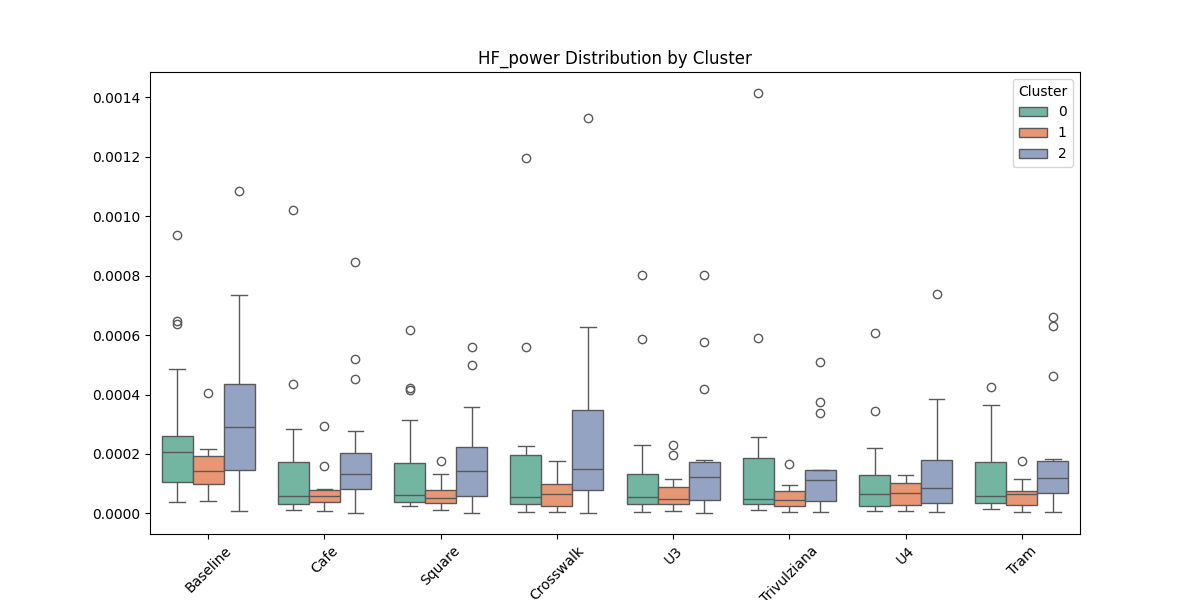

📌 Significant difference found when comparing Cluster 2 against the rest of the dataset. p-value = 4.87e-06
📌 Significant difference found when comparing Cluster 1 against the rest of the dataset. p-value = 1.66e-05

 STATISTICAL ANALYSIS: COMPARING CLUSTERS AGAINST EACH OTHER
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
     0      1  -0.0001 0.0032 -0.0001   -0.0   True
     0      2      0.0 0.0994    -0.0 0.0001  False
     1      2   0.0001    0.0  0.0001 0.0002   True
---------------------------------------------------

 STATISTICAL ANALYSIS: COMPARING POIS AGAINST EACH OTHER
--- Within Cluster 0
     Multiple Comparison of Means - Tukey HSD, FWER=0.05     
   group1      group2   meandiff p-adj   lower  upper  reject
-------------------------------------------------------------
       Cafe   Crosswalk     -0.0    1.0 -0.0001 0.0001  False
       Cafe      Square     -0.

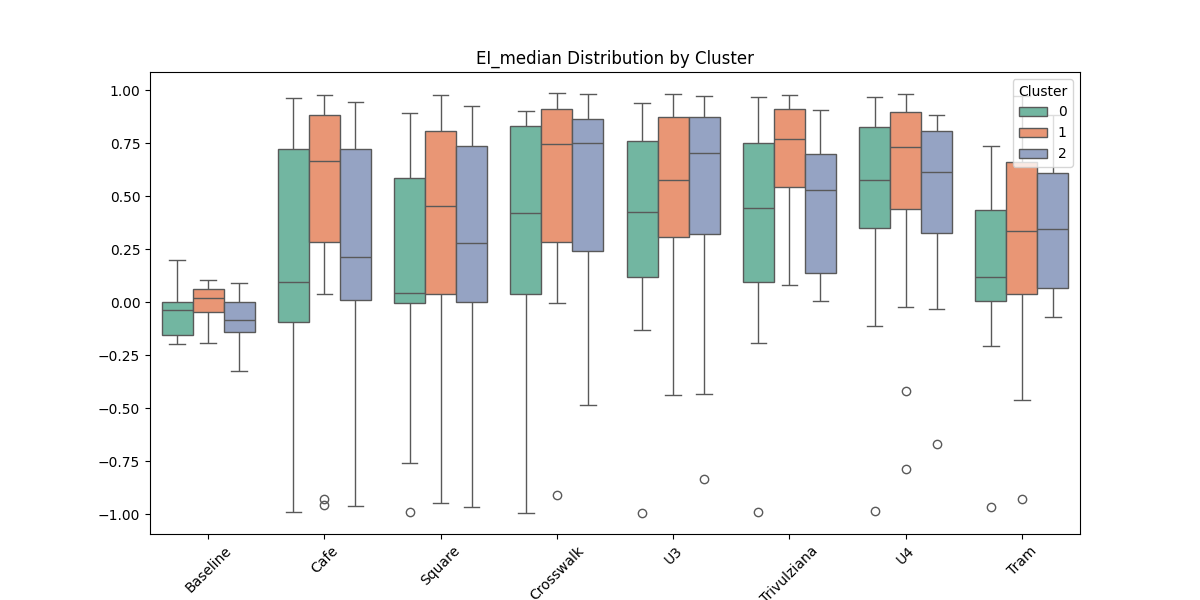

📌 Significant difference found when comparing Cluster 0 against the rest of the dataset. p-value = 5.04e-03
📌 Significant difference found when comparing Cluster 1 against the rest of the dataset. p-value = 3.85e-03

 STATISTICAL ANALYSIS: COMPARING CLUSTERS AGAINST EACH OTHER
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
     0      1   0.1737 0.0201   0.022 0.3254   True
     0      2   0.0998 0.2698 -0.0519 0.2515  False
     1      2  -0.0739  0.541 -0.2385 0.0906  False
---------------------------------------------------

 STATISTICAL ANALYSIS: COMPARING POIS AGAINST EACH OTHER
--- Within Cluster 0
     Multiple Comparison of Means - Tukey HSD, FWER=0.05     
   group1      group2   meandiff p-adj   lower  upper  reject
-------------------------------------------------------------
       Cafe   Crosswalk   0.1778 0.5515 -0.1158 0.4714  False
       Cafe      Square  -0.051

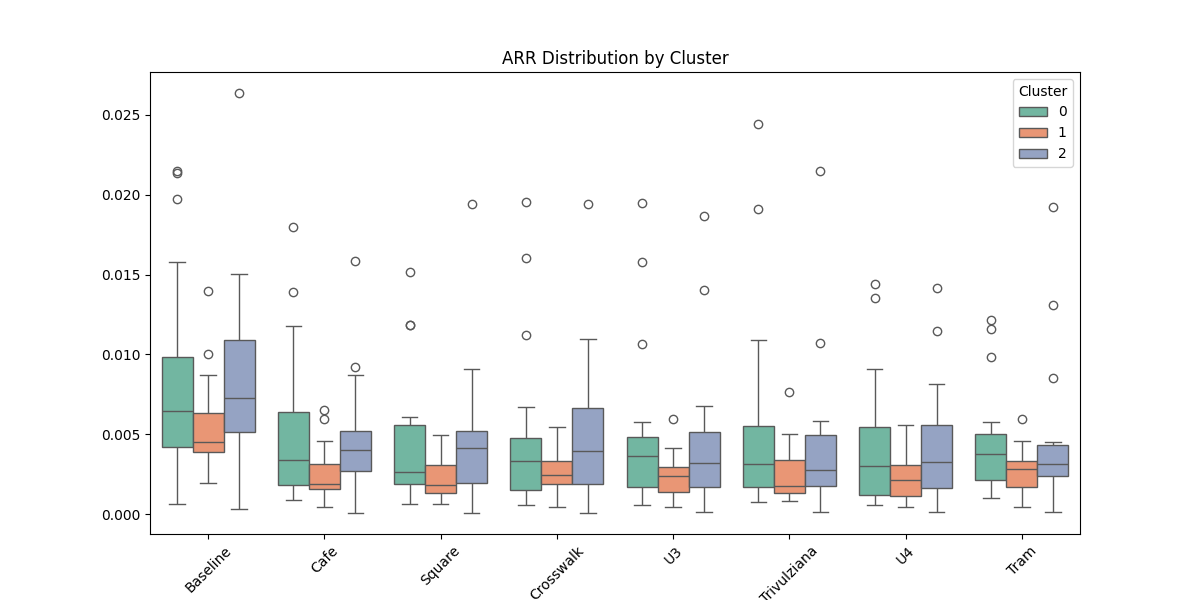

📌 Significant difference found when comparing Cluster 0 against the rest of the dataset. p-value = 3.33e-02
📌 Significant difference found when comparing Cluster 1 against the rest of the dataset. p-value = 2.63e-05

 STATISTICAL ANALYSIS: COMPARING CLUSTERS AGAINST EACH OTHER
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
     0      1  -0.0022 0.0001 -0.0035 -0.001   True
     0      2   0.0002 0.8976  -0.001 0.0015  False
     1      2   0.0024 0.0001  0.0011 0.0038   True
---------------------------------------------------

 STATISTICAL ANALYSIS: COMPARING POIS AGAINST EACH OTHER
--- Within Cluster 0
     Multiple Comparison of Means - Tukey HSD, FWER=0.05     
   group1      group2   meandiff p-adj   lower  upper  reject
-------------------------------------------------------------
       Cafe   Crosswalk   0.0001    1.0 -0.0025 0.0026  False
       Cafe      Square  -0.000

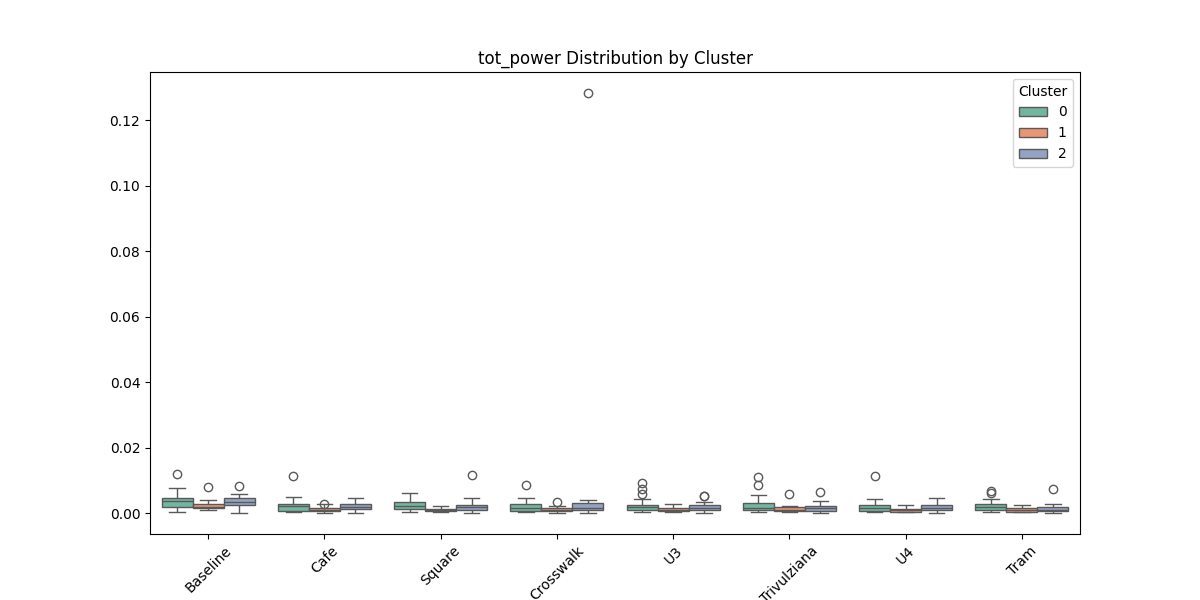

📌 Significant difference found when comparing Cluster 0 against the rest of the dataset. p-value = 6.26e-04
📌 Significant difference found when comparing Cluster 1 against the rest of the dataset. p-value = 2.71e-06

 STATISTICAL ANALYSIS: COMPARING CLUSTERS AGAINST EACH OTHER
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
     0      1  -0.0012    0.0 -0.0018 -0.0007   True
     0      2  -0.0004 0.2757 -0.0009  0.0002  False
     1      2   0.0009 0.0032  0.0002  0.0015   True
----------------------------------------------------

 STATISTICAL ANALYSIS: COMPARING POIS AGAINST EACH OTHER
--- Within Cluster 0
--- Without Cluster 0
--- Within Cluster 1
--- Without Cluster 1
--- Within Cluster 2
--- Without Cluster 2
--- Full dataset
Processing: PDA


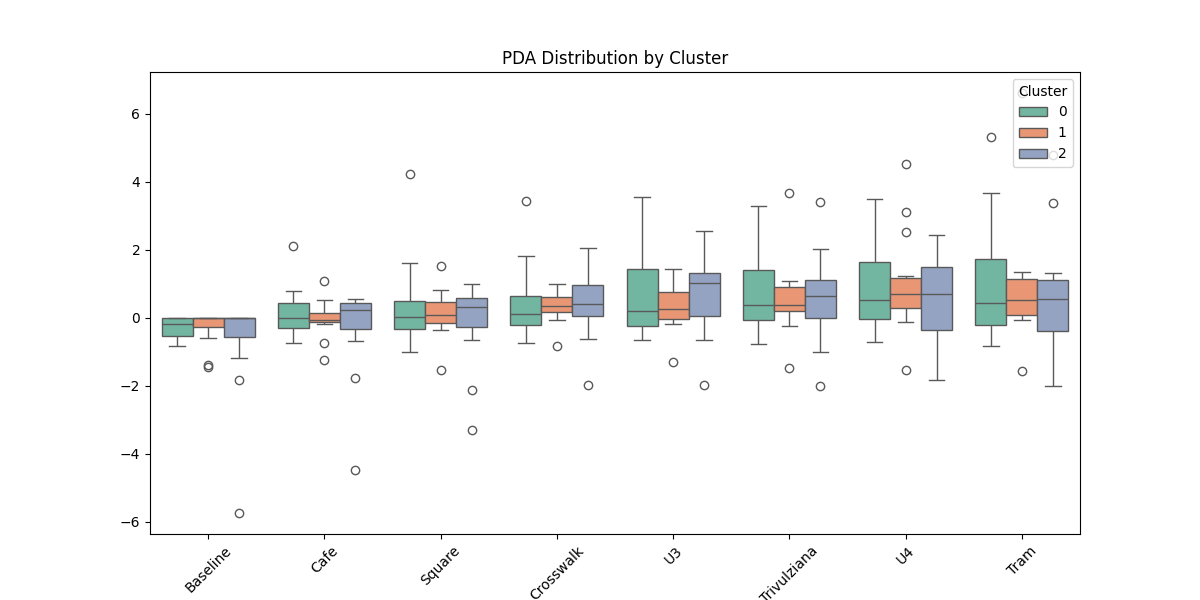


 STATISTICAL ANALYSIS: COMPARING CLUSTERS AGAINST EACH OTHER

 STATISTICAL ANALYSIS: COMPARING POIS AGAINST EACH OTHER
--- Within Cluster 0
     Multiple Comparison of Means - Tukey HSD, FWER=0.05     
   group1      group2   meandiff p-adj   lower  upper  reject
-------------------------------------------------------------
       Cafe   Crosswalk    0.433 0.5123 -0.2597 1.1256  False
       Cafe      Square   0.1719 0.9902 -0.5208 0.8645  False
       Cafe        Tram   0.9206 0.0019   0.228 1.6133   True
       Cafe Trivulziana   0.7024 0.0444  0.0097  1.395   True
       Cafe          U3   0.5814 0.1663 -0.1113  1.274  False
       Cafe          U4    0.869 0.0043  0.1764 1.5617   True
  Crosswalk      Square  -0.2611 0.9222 -0.9538 0.4315  False
  Crosswalk        Tram   0.4876  0.362  -0.205 1.1803  False
  Crosswalk Trivulziana   0.2694 0.9107 -0.4233  0.962  False
  Crosswalk          U3   0.1484 0.9956 -0.5443  0.841  False
  Crosswalk          U4    0.436 0.5035 -0.2566 1.128

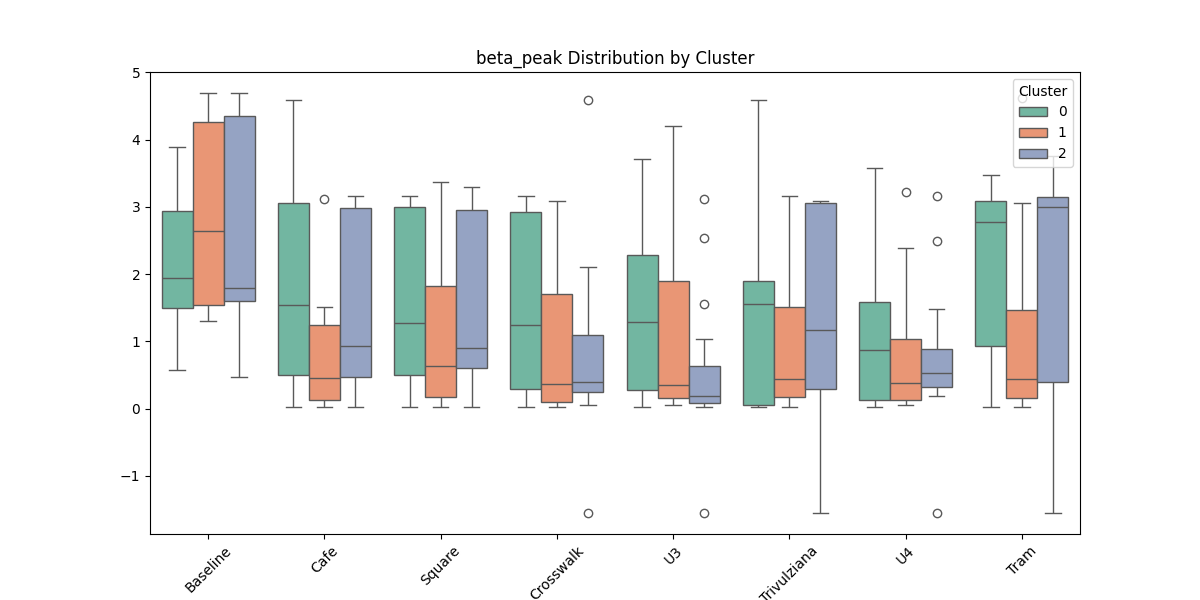

📌 Significant difference found when comparing Cluster 0 against the rest of the dataset. p-value = 2.78e-02
📌 Significant difference found when comparing Cluster 1 against the rest of the dataset. p-value = 5.29e-03

 STATISTICAL ANALYSIS: COMPARING CLUSTERS AGAINST EACH OTHER
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
     0      1  -0.5973 0.0012 -0.9922 -0.2023   True
     0      2   -0.329  0.105 -0.7091  0.0512  False
     1      2   0.2683 0.2816 -0.1465  0.6831  False
----------------------------------------------------

 STATISTICAL ANALYSIS: COMPARING POIS AGAINST EACH OTHER
--- Within Cluster 0
--- Without Cluster 0
--- Within Cluster 1
--- Without Cluster 1
--- Within Cluster 2
--- Without Cluster 2
--- Full dataset
Processing: LFHF_PP_MEDIAN


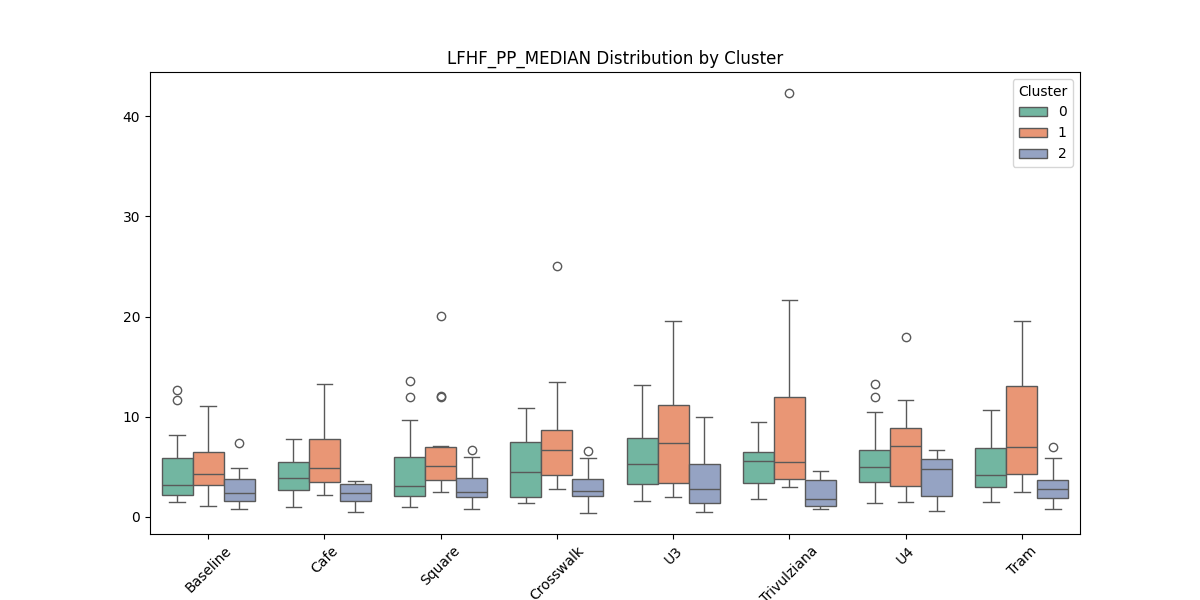

📌 Significant difference found when comparing Cluster 2 against the rest of the dataset. p-value = 2.31e-15
📌 Significant difference found when comparing Cluster 1 against the rest of the dataset. p-value = 3.84e-11

 STATISTICAL ANALYSIS: COMPARING CLUSTERS AGAINST EACH OTHER
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
     0      1   2.8047    0.0  1.5353  4.0742   True
     0      2  -1.9496 0.0007 -3.1913  -0.708   True
     1      2  -4.7544    0.0 -6.1268 -3.3819   True
----------------------------------------------------

 STATISTICAL ANALYSIS: COMPARING POIS AGAINST EACH OTHER
--- Within Cluster 0
     Multiple Comparison of Means - Tukey HSD, FWER=0.05     
   group1      group2   meandiff p-adj   lower  upper  reject
-------------------------------------------------------------
       Cafe   Crosswalk   1.1142 0.8815 -1.5704 3.7988  False
       Cafe      Square 

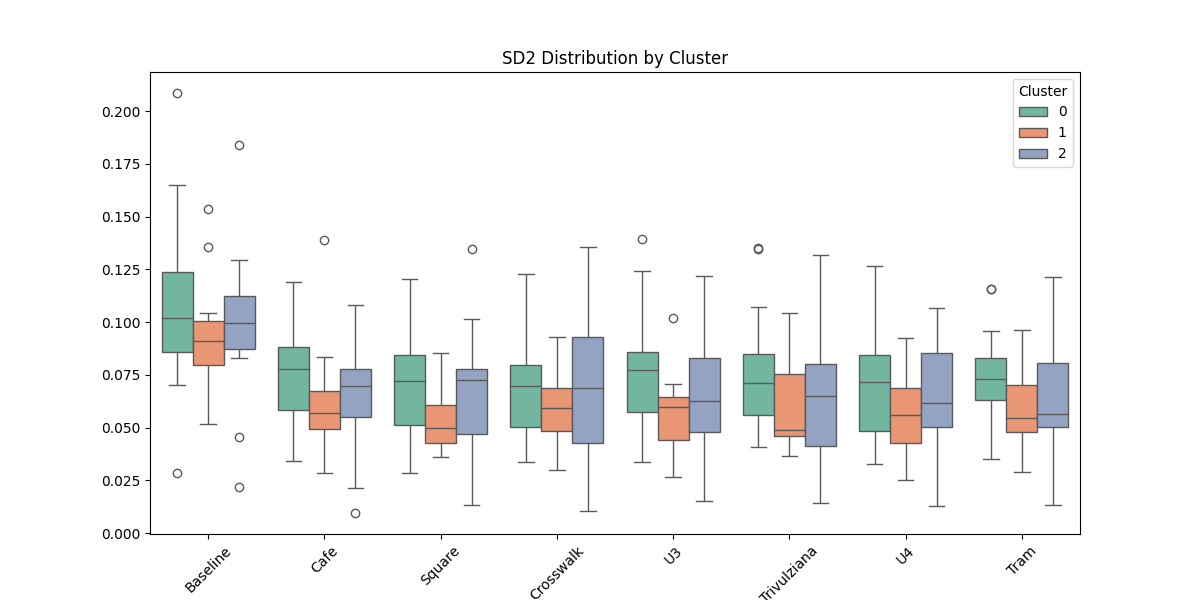

📌 Significant difference found when comparing Cluster 0 against the rest of the dataset. p-value = 1.73e-04
📌 Significant difference found when comparing Cluster 1 against the rest of the dataset. p-value = 6.86e-05

 STATISTICAL ANALYSIS: COMPARING CLUSTERS AGAINST EACH OTHER
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
     0      1  -0.0149    0.0 -0.0226 -0.0072   True
     0      2  -0.0065 0.1149 -0.0142  0.0012  False
     1      2   0.0084 0.0476  0.0001  0.0167   True
----------------------------------------------------

 STATISTICAL ANALYSIS: COMPARING POIS AGAINST EACH OTHER
--- Within Cluster 0
--- Without Cluster 0
--- Within Cluster 1
--- Without Cluster 1
--- Within Cluster 2
--- Without Cluster 2
--- Full dataset
Processing: SD1


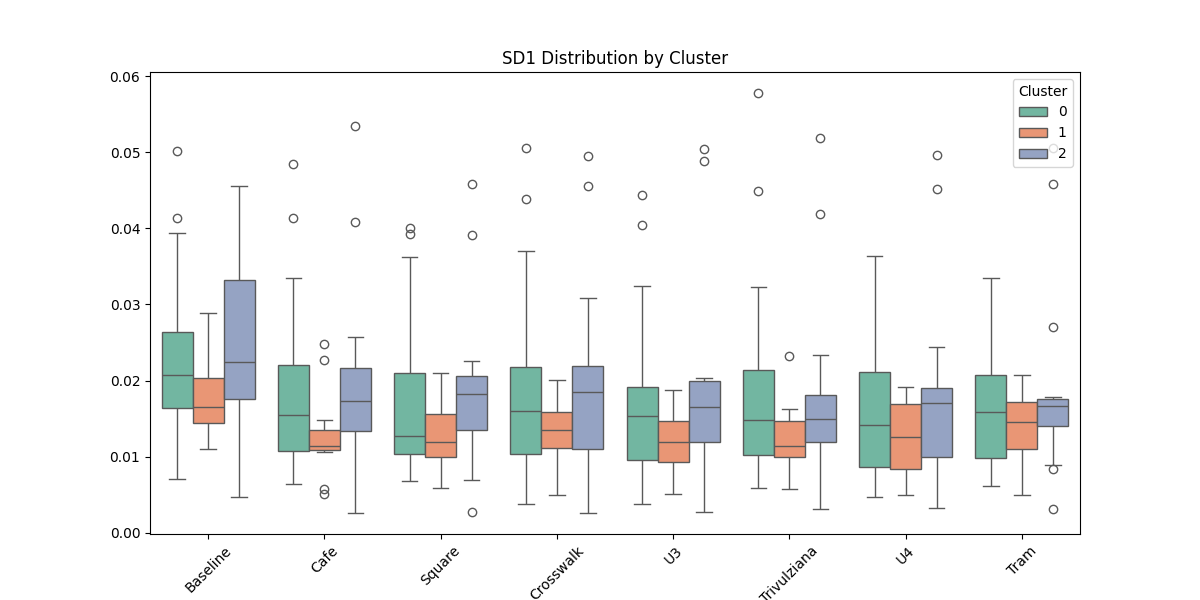

📌 Significant difference found when comparing Cluster 2 against the rest of the dataset. p-value = 2.34e-03
📌 Significant difference found when comparing Cluster 1 against the rest of the dataset. p-value = 2.90e-05

 STATISTICAL ANALYSIS: COMPARING CLUSTERS AGAINST EACH OTHER
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
     0      1  -0.0047 0.0014 -0.0078 -0.0016   True
     0      2   0.0023 0.2091 -0.0009  0.0054  False
     1      2   0.0069    0.0  0.0035  0.0103   True
----------------------------------------------------

 STATISTICAL ANALYSIS: COMPARING POIS AGAINST EACH OTHER
--- Within Cluster 0
     Multiple Comparison of Means - Tukey HSD, FWER=0.05     
   group1      group2   meandiff p-adj   lower  upper  reject
-------------------------------------------------------------
       Cafe   Crosswalk   0.0003    1.0 -0.0061 0.0066  False
       Cafe      Square 

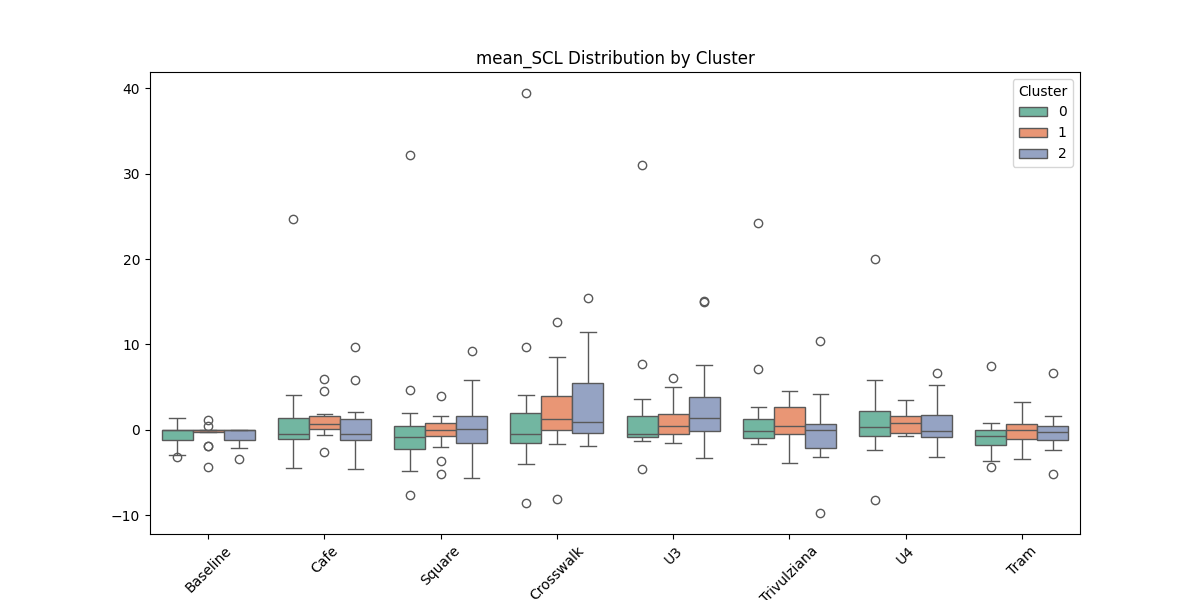

📌 Significant difference found when comparing Cluster 0 against the rest of the dataset. p-value = 1.80e-02
📌 Significant difference found when comparing Cluster 1 against the rest of the dataset. p-value = 1.33e-02

 STATISTICAL ANALYSIS: COMPARING CLUSTERS AGAINST EACH OTHER
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
     0      1  -0.2781 0.9053 -1.8182 1.2621  False
     0      2  -0.0244 0.9992 -1.5341 1.4852  False
     1      2   0.2536 0.9298 -1.3888 1.8961  False
---------------------------------------------------

 STATISTICAL ANALYSIS: COMPARING POIS AGAINST EACH OTHER
--- Within Cluster 0
     Multiple Comparison of Means - Tukey HSD, FWER=0.05     
   group1      group2   meandiff p-adj   lower  upper  reject
-------------------------------------------------------------
       Cafe   Crosswalk   1.3553 0.8219 -1.5979 4.3085  False
       Cafe      Square   -0.55

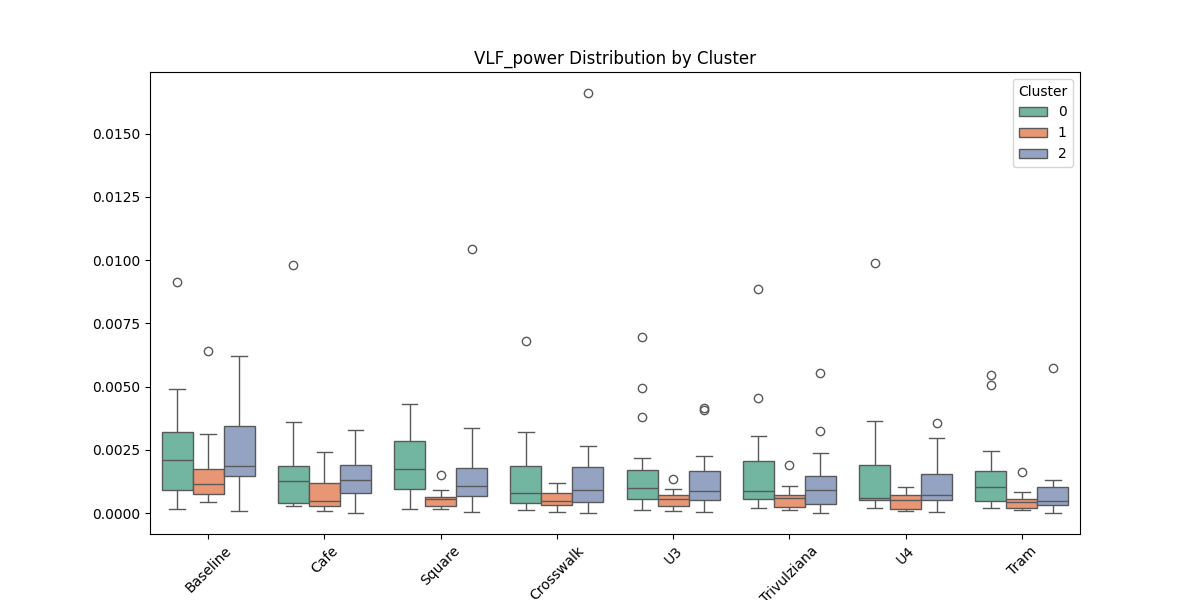

📌 Significant difference found when comparing Cluster 0 against the rest of the dataset. p-value = 1.84e-05
📌 Significant difference found when comparing Cluster 1 against the rest of the dataset. p-value = 1.96e-09

 STATISTICAL ANALYSIS: COMPARING CLUSTERS AGAINST EACH OTHER
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
     0      1  -0.0011    0.0 -0.0015 -0.0006   True
     0      2  -0.0003 0.3565 -0.0007  0.0002  False
     1      2   0.0008 0.0003  0.0003  0.0013   True
----------------------------------------------------

 STATISTICAL ANALYSIS: COMPARING POIS AGAINST EACH OTHER
--- Within Cluster 0
     Multiple Comparison of Means - Tukey HSD, FWER=0.05     
   group1      group2   meandiff p-adj   lower  upper  reject
-------------------------------------------------------------
       Cafe   Crosswalk  -0.0003 0.9418 -0.0012 0.0006  False
       Cafe      Square 

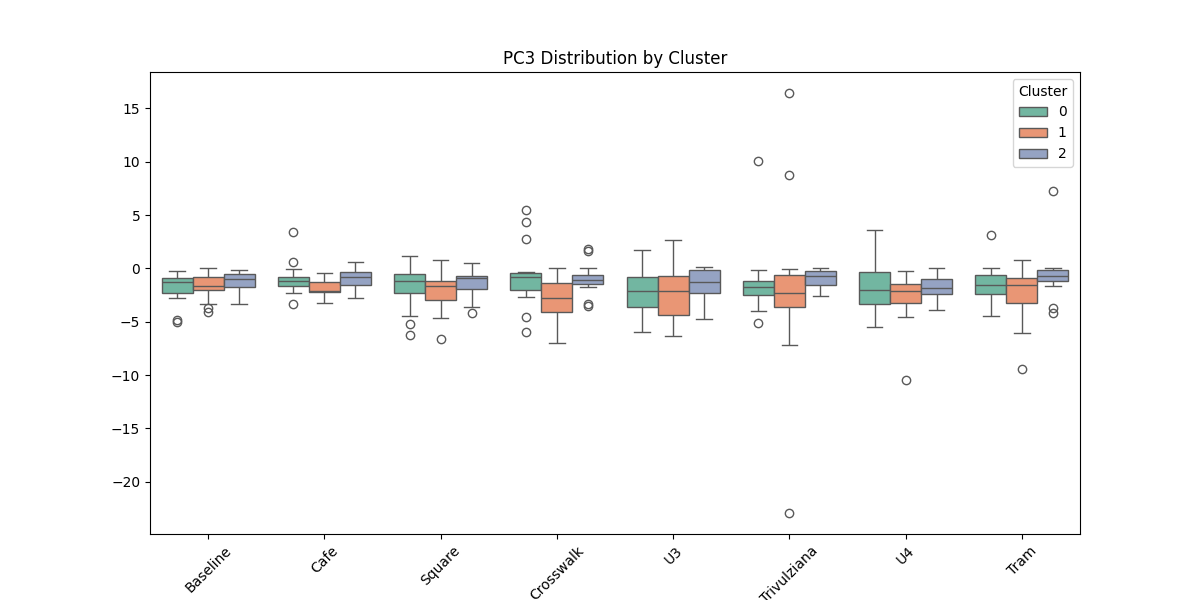

📌 Significant difference found when comparing Cluster 2 against the rest of the dataset. p-value = 2.89e-05
📌 Significant difference found when comparing Cluster 1 against the rest of the dataset. p-value = 2.88e-05

 STATISTICAL ANALYSIS: COMPARING CLUSTERS AGAINST EACH OTHER
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
     0      1  -0.8489 0.0293 -1.6297 -0.068   True
     0      2   0.3261 0.5639 -0.4254 1.0777  False
     1      2    1.175 0.0024   0.355  1.995   True
---------------------------------------------------

 STATISTICAL ANALYSIS: COMPARING POIS AGAINST EACH OTHER
--- Within Cluster 0
     Multiple Comparison of Means - Tukey HSD, FWER=0.05     
   group1      group2   meandiff p-adj   lower  upper  reject
-------------------------------------------------------------
       Cafe   Crosswalk  -0.2242 0.9995 -1.7411 1.2928  False
       Cafe      Square  -0.519

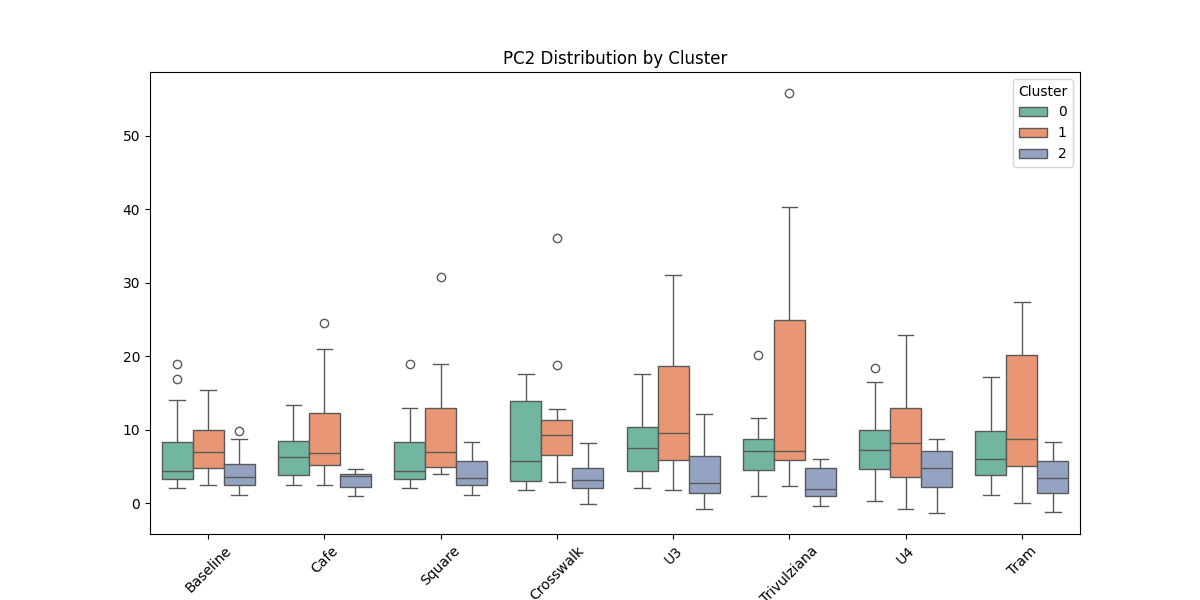

📌 Significant difference found when comparing Cluster 0 against the rest of the dataset. p-value = 5.74e-03
📌 Significant difference found when comparing Cluster 2 against the rest of the dataset. p-value = 1.70e-19
📌 Significant difference found when comparing Cluster 1 against the rest of the dataset. p-value = 1.91e-10

 STATISTICAL ANALYSIS: COMPARING CLUSTERS AGAINST EACH OTHER
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower   upper  reject
---------------------------------------------------
     0      1   4.0612   0.0  2.2007  5.9217   True
     0      2  -3.7399   0.0 -5.5307 -1.9491   True
     1      2  -7.8011   0.0  -9.755 -5.8472   True
---------------------------------------------------

 STATISTICAL ANALYSIS: COMPARING POIS AGAINST EACH OTHER
--- Within Cluster 0
--- Without Cluster 0
--- Within Cluster 1
--- Without Cluster 1
--- Within Cluster 2
--- Without Cluster 2
--- Full dataset
Processing: SD1SD2


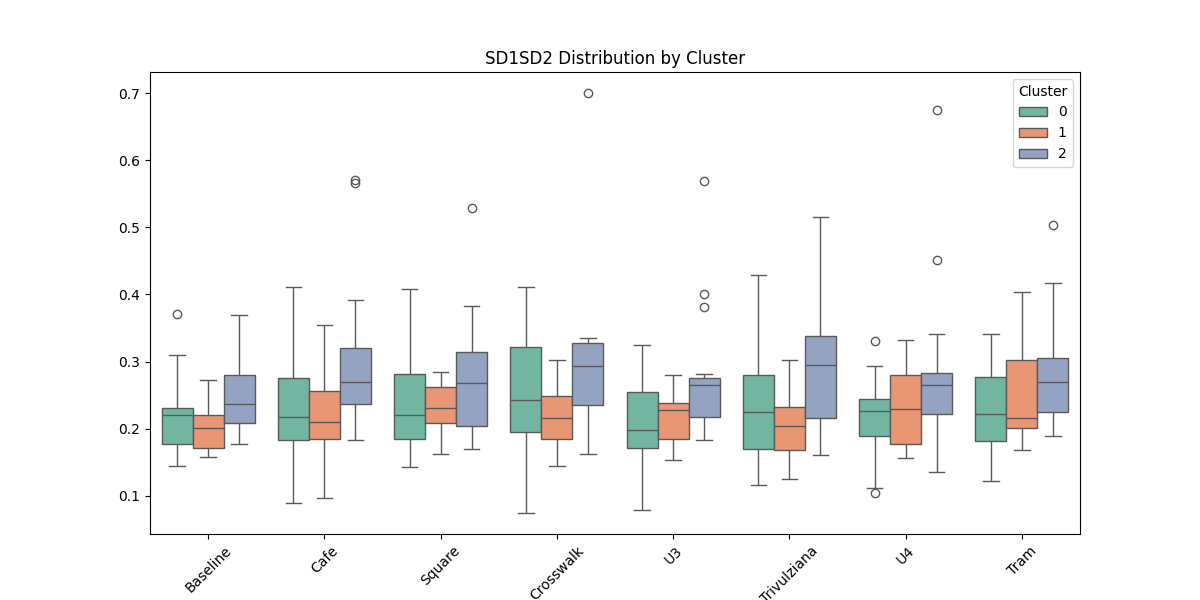

📌 Significant difference found when comparing Cluster 0 against the rest of the dataset. p-value = 3.80e-03
📌 Significant difference found when comparing Cluster 2 against the rest of the dataset. p-value = 1.77e-09
📌 Significant difference found when comparing Cluster 1 against the rest of the dataset. p-value = 2.34e-03

 STATISTICAL ANALYSIS: COMPARING CLUSTERS AGAINST EACH OTHER
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
     0      1  -0.0031 0.9564 -0.0285 0.0223  False
     0      2   0.0617    0.0  0.0363  0.087   True
     1      2   0.0647    0.0  0.0372 0.0923   True
---------------------------------------------------

 STATISTICAL ANALYSIS: COMPARING POIS AGAINST EACH OTHER
--- Within Cluster 0
     Multiple Comparison of Means - Tukey HSD, FWER=0.05     
   group1      group2   meandiff p-adj   lower  upper  reject
-----------------------------------------------

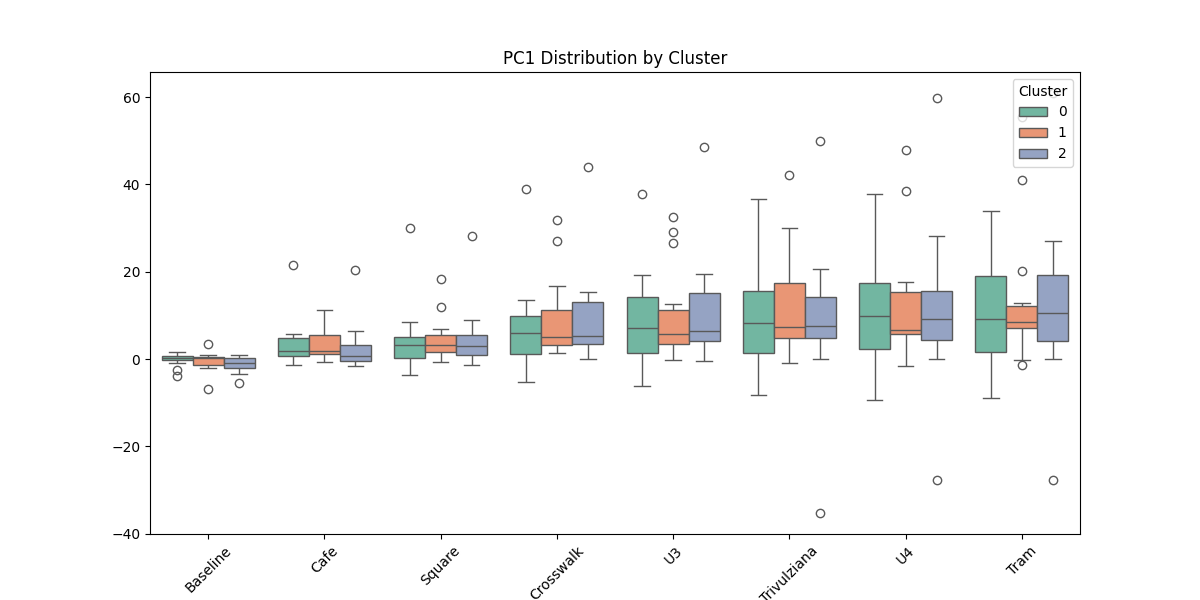


 STATISTICAL ANALYSIS: COMPARING CLUSTERS AGAINST EACH OTHER

 STATISTICAL ANALYSIS: COMPARING POIS AGAINST EACH OTHER
--- Within Cluster 0
      Multiple Comparison of Means - Tukey HSD, FWER=0.05      
   group1      group2   meandiff p-adj   lower    upper  reject
---------------------------------------------------------------
       Cafe   Crosswalk   5.1911 0.2259   -1.375 11.7572  False
       Cafe      Square   1.3119  0.997  -5.2542   7.878  False
       Cafe        Tram    9.103  0.001   2.5369 15.6691   True
       Cafe Trivulziana   6.9037 0.0321   0.3376 13.4698   True
       Cafe          U3    6.606 0.0475   0.0399 13.1721   True
       Cafe          U4   8.3776 0.0034   1.8115 14.9437   True
  Crosswalk      Square  -3.8793 0.5813 -10.4454  2.6868  False
  Crosswalk        Tram   3.9119 0.5713  -2.6542  10.478  False
  Crosswalk Trivulziana   1.7126 0.9873  -4.8535  8.2787  False
  Crosswalk          U3   1.4149 0.9955  -5.1512   7.981  False
  Crosswalk          U4   3

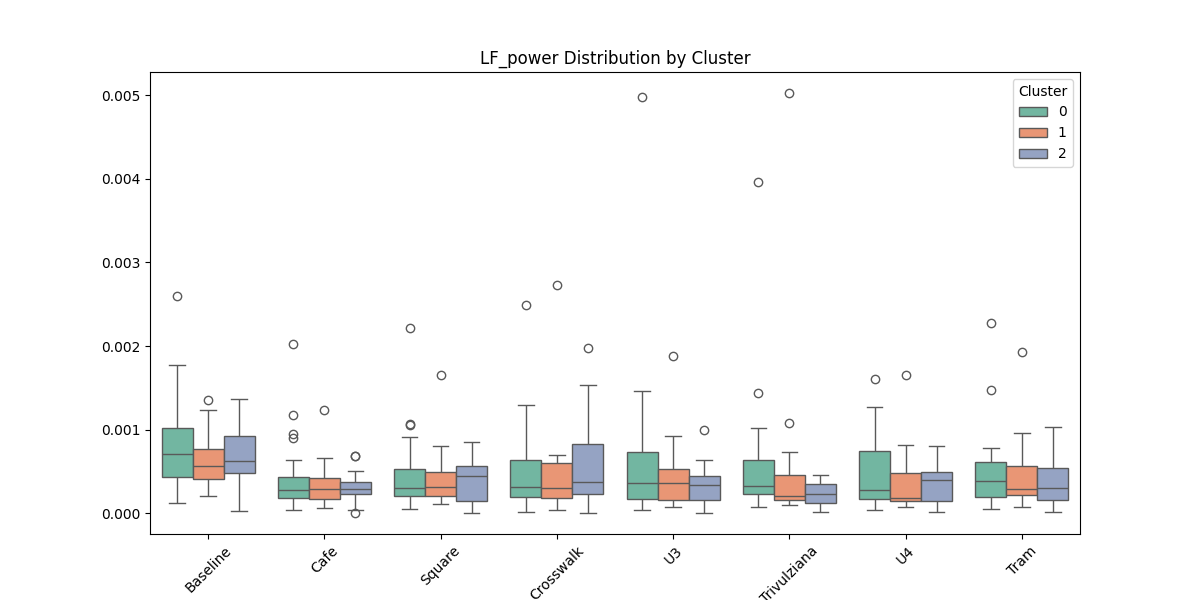


 STATISTICAL ANALYSIS: COMPARING CLUSTERS AGAINST EACH OTHER

 STATISTICAL ANALYSIS: COMPARING POIS AGAINST EACH OTHER
--- Within Cluster 0
     Multiple Comparison of Means - Tukey HSD, FWER=0.05     
   group1      group2   meandiff p-adj   lower  upper  reject
-------------------------------------------------------------
       Cafe   Crosswalk   0.0001 0.9523 -0.0002 0.0005  False
       Cafe      Square   0.0001 0.9986 -0.0003 0.0004  False
       Cafe        Tram   0.0001 0.9896 -0.0003 0.0004  False
       Cafe Trivulziana   0.0001 0.9277 -0.0002 0.0005  False
       Cafe          U3   0.0001  0.918 -0.0002 0.0005  False
       Cafe          U4      0.0 0.9999 -0.0003 0.0004  False
  Crosswalk      Square  -0.0001  0.999 -0.0004 0.0003  False
  Crosswalk        Tram     -0.0    1.0 -0.0004 0.0003  False
  Crosswalk Trivulziana      0.0    1.0 -0.0003 0.0004  False
  Crosswalk          U3      0.0    1.0 -0.0003 0.0004  False
  Crosswalk          U4  -0.0001 0.9916 -0.0004 0.000

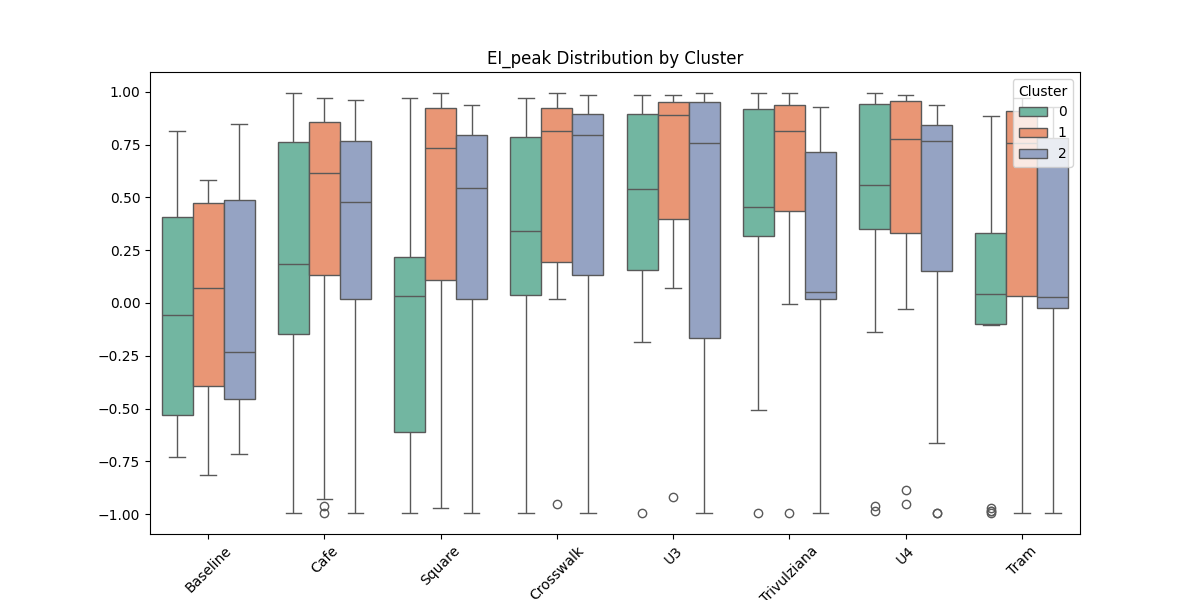

📌 Significant difference found when comparing Cluster 0 against the rest of the dataset. p-value = 3.08e-02
📌 Significant difference found when comparing Cluster 1 against the rest of the dataset. p-value = 1.01e-03

 STATISTICAL ANALYSIS: COMPARING CLUSTERS AGAINST EACH OTHER
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
     0      1   0.2241  0.017  0.0326 0.4156   True
     0      2   0.0545 0.7661 -0.1298 0.2388  False
     1      2  -0.1696 0.1174 -0.3707 0.0315  False
---------------------------------------------------

 STATISTICAL ANALYSIS: COMPARING POIS AGAINST EACH OTHER
--- Within Cluster 0
     Multiple Comparison of Means - Tukey HSD, FWER=0.05     
   group1      group2   meandiff p-adj   lower  upper  reject
-------------------------------------------------------------
       Cafe   Crosswalk   0.1131 0.9705 -0.2547 0.4809  False
       Cafe      Square  -0.049

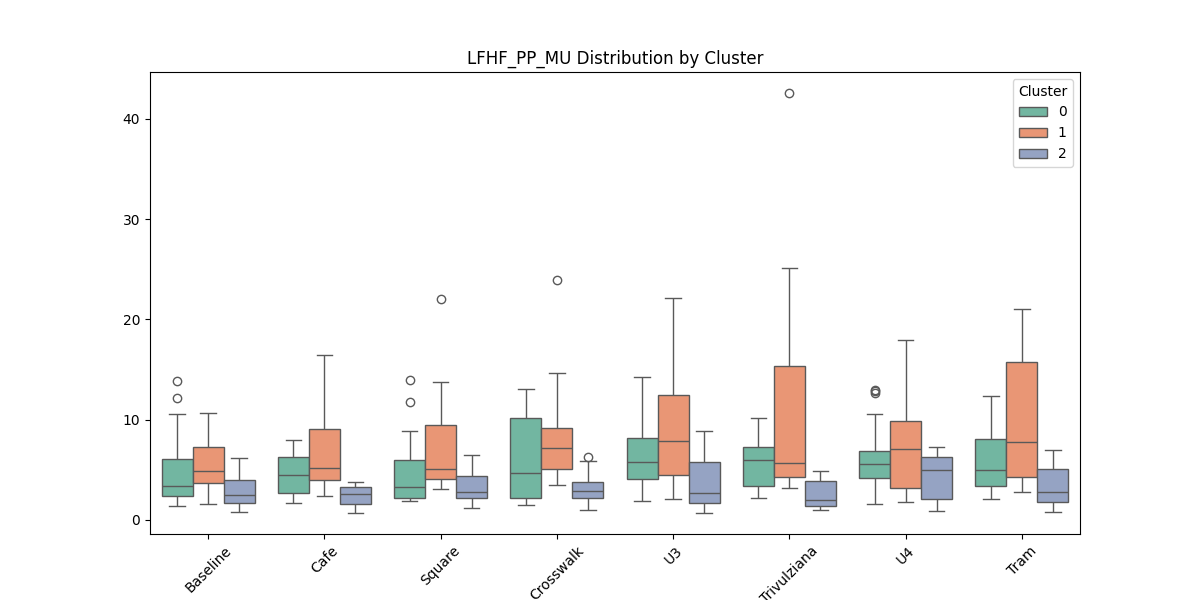

📌 Significant difference found when comparing Cluster 2 against the rest of the dataset. p-value = 1.17e-17
📌 Significant difference found when comparing Cluster 1 against the rest of the dataset. p-value = 1.11e-11

 STATISTICAL ANALYSIS: COMPARING CLUSTERS AGAINST EACH OTHER
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
     0      1   3.1132    0.0  1.7517  4.4746   True
     0      2  -2.3922 0.0001 -3.7239 -1.0605   True
     1      2  -5.5053    0.0 -6.9773 -4.0334   True
----------------------------------------------------

 STATISTICAL ANALYSIS: COMPARING POIS AGAINST EACH OTHER
--- Within Cluster 0
     Multiple Comparison of Means - Tukey HSD, FWER=0.05     
   group1      group2   meandiff p-adj   lower  upper  reject
-------------------------------------------------------------
       Cafe   Crosswalk   1.3019 0.8401 -1.6147 4.2185  False
       Cafe      Square 

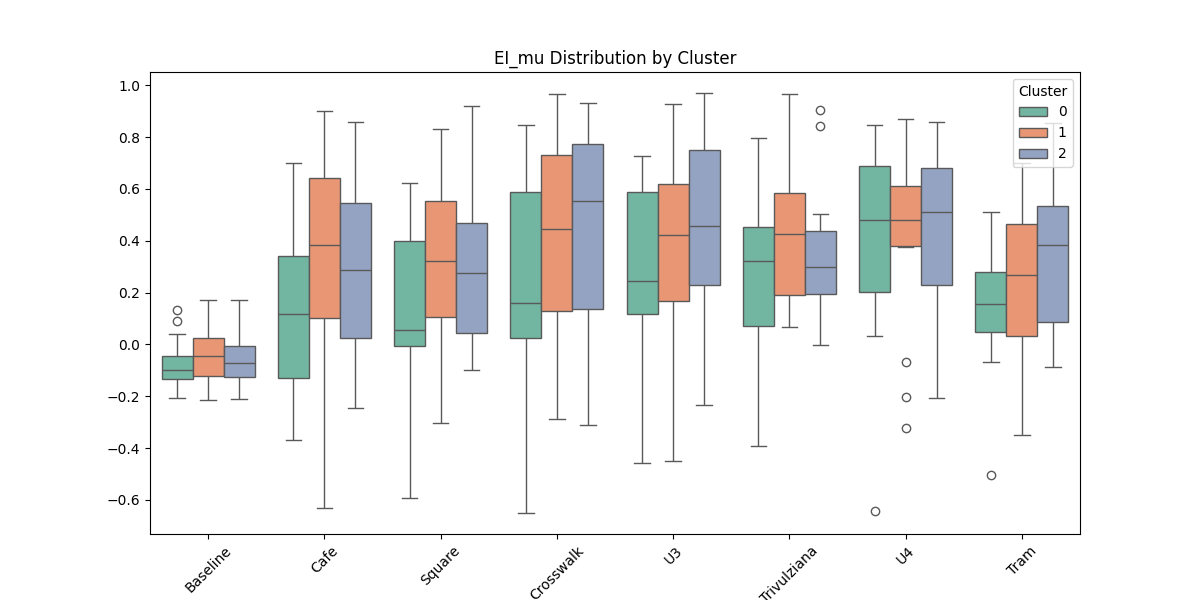

📌 Significant difference found when comparing Cluster 0 against the rest of the dataset. p-value = 2.11e-03

 STATISTICAL ANALYSIS: COMPARING CLUSTERS AGAINST EACH OTHER
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
     0      1   0.1234  0.018  0.0172 0.2296   True
     0      2   0.1251 0.0161  0.0189 0.2313   True
     1      2   0.0017 0.9993 -0.1135 0.1169  False
---------------------------------------------------

 STATISTICAL ANALYSIS: COMPARING POIS AGAINST EACH OTHER
--- Within Cluster 0
     Multiple Comparison of Means - Tukey HSD, FWER=0.05     
   group1      group2   meandiff p-adj   lower  upper  reject
-------------------------------------------------------------
       Cafe   Crosswalk   0.1295 0.5137 -0.0779 0.3368  False
       Cafe      Square   0.0021    1.0 -0.2052 0.2095  False
       Cafe        Tram   0.0047    1.0 -0.2026 0.2121  False
       Cafe Tri

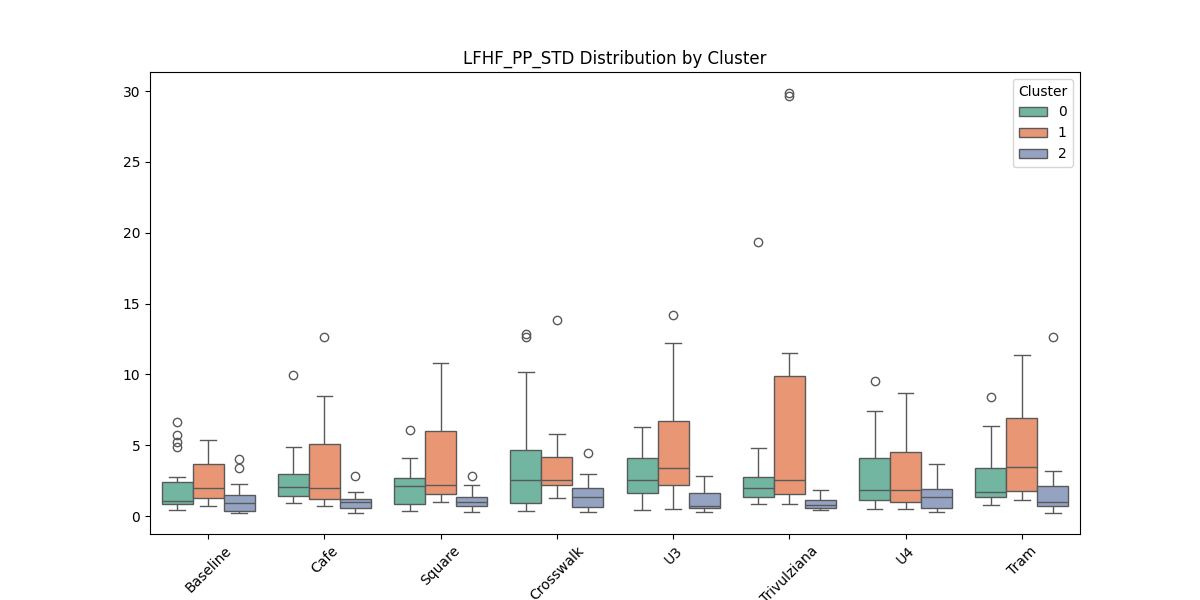

📌 Significant difference found when comparing Cluster 0 against the rest of the dataset. p-value = 7.37e-03
📌 Significant difference found when comparing Cluster 2 against the rest of the dataset. p-value = 1.21e-18
📌 Significant difference found when comparing Cluster 1 against the rest of the dataset. p-value = 7.57e-10

 STATISTICAL ANALYSIS: COMPARING CLUSTERS AGAINST EACH OTHER
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
     0      1   1.7587 0.0003  0.7144   2.803   True
     0      2  -1.5429 0.0013 -2.5644 -0.5214   True
     1      2  -3.3016    0.0 -4.4306 -2.1725   True
----------------------------------------------------

 STATISTICAL ANALYSIS: COMPARING POIS AGAINST EACH OTHER
--- Within Cluster 0
--- Without Cluster 0
--- Within Cluster 1
--- Without Cluster 1
--- Within Cluster 2
--- Without Cluster 2
--- Full dataset
Processing: SDRR


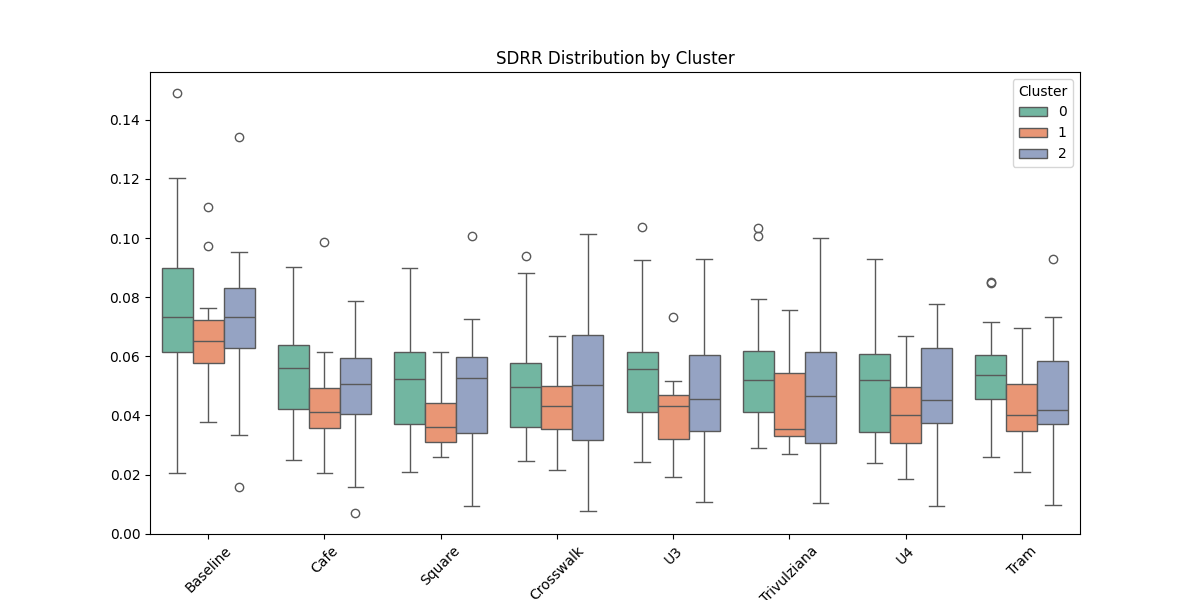

📌 Significant difference found when comparing Cluster 0 against the rest of the dataset. p-value = 4.20e-04
📌 Significant difference found when comparing Cluster 1 against the rest of the dataset. p-value = 3.68e-05

 STATISTICAL ANALYSIS: COMPARING CLUSTERS AGAINST EACH OTHER
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
     0      1  -0.0111    0.0 -0.0169 -0.0053   True
     0      2  -0.0056 0.0543 -0.0112  0.0001  False
     1      2   0.0055 0.0891 -0.0006  0.0117  False
----------------------------------------------------

 STATISTICAL ANALYSIS: COMPARING POIS AGAINST EACH OTHER
--- Within Cluster 0
--- Without Cluster 0
--- Within Cluster 1
--- Without Cluster 1
--- Within Cluster 2
--- Without Cluster 2
--- Full dataset
Processing: SDSD


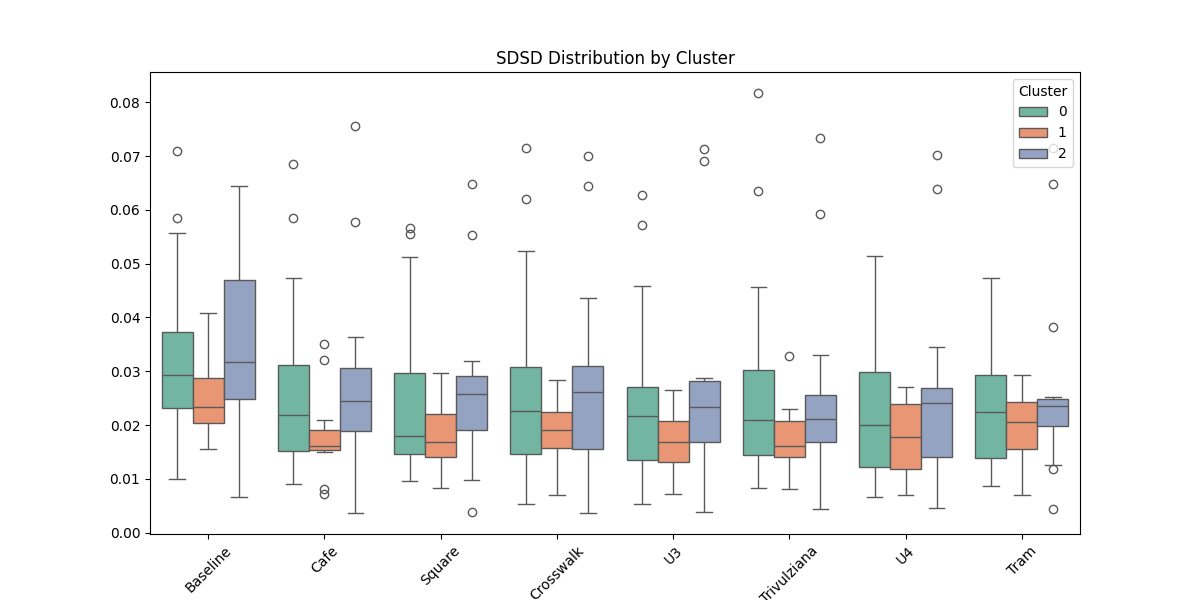

📌 Significant difference found when comparing Cluster 2 against the rest of the dataset. p-value = 2.34e-03
📌 Significant difference found when comparing Cluster 1 against the rest of the dataset. p-value = 2.90e-05

 STATISTICAL ANALYSIS: COMPARING CLUSTERS AGAINST EACH OTHER
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
     0      1  -0.0066 0.0014 -0.0111 -0.0022   True
     0      2   0.0032 0.2091 -0.0012  0.0076  False
     1      2   0.0098    0.0   0.005  0.0146   True
----------------------------------------------------

 STATISTICAL ANALYSIS: COMPARING POIS AGAINST EACH OTHER
--- Within Cluster 0
     Multiple Comparison of Means - Tukey HSD, FWER=0.05     
   group1      group2   meandiff p-adj   lower  upper  reject
-------------------------------------------------------------
       Cafe   Crosswalk   0.0004    1.0 -0.0086 0.0094  False
       Cafe      Square 

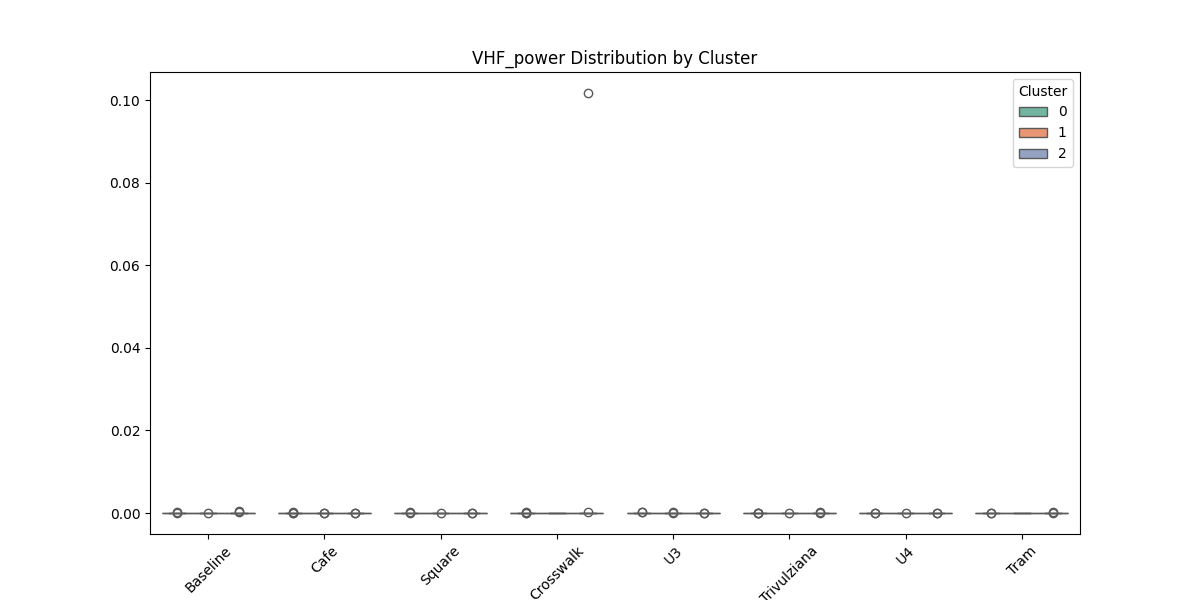

📌 Significant difference found when comparing Cluster 2 against the rest of the dataset. p-value = 3.91e-03
📌 Significant difference found when comparing Cluster 1 against the rest of the dataset. p-value = 1.03e-05

 STATISTICAL ANALYSIS: COMPARING CLUSTERS AGAINST EACH OTHER
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower upper reject
------------------------------------------------
     0      1     -0.0 0.0011  -0.0  -0.0   True
     0      2      0.0 0.9993  -0.0   0.0  False
     1      2      0.0 0.0025   0.0   0.0   True
------------------------------------------------

 STATISTICAL ANALYSIS: COMPARING POIS AGAINST EACH OTHER
--- Within Cluster 0
   Multiple Comparison of Means - Tukey HSD, FWER=0.05    
   group1      group2   meandiff p-adj  lower upper reject
----------------------------------------------------------
       Cafe   Crosswalk      0.0 0.9845  -0.0   0.0  False
       Cafe      Square     -0.0  0.995  -0.0   0.0  False
  

In [311]:
# CREATE BOXPLOTS OF THE METRICS, HIGHLIGHTING THE DIFFERENCES BETWEEN CLUSTERS

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy.stats as stats
from scikit_posthocs import posthoc_tukey_hsd
from statsmodels.stats.multicomp import pairwise_tukeyhsd


%matplotlib widget
f = {}
F = {}
IQR_factor = 1.5  # Standard IQR multiplier
t = False

# Determine the number of unique clusters
num_clusters = int(pearson_clusters['Cluster'].nunique())

# Generate a color palette with the required number of colors
palette = sns.color_palette('Set2', n_colors=num_clusters)

# Ensure clusters are sorted in numeric order (0, 1, 2, etc.)
cluster_labels = sorted(pearson_clusters['Cluster'].unique(), key=int)

# Map cluster labels to colors dynamically
cluster_colors = {label: palette[i] for i, label in enumerate(cluster_labels)}

# Convert RGB colors to ANSI escape codes for terminal printing
def rgb_to_ansi(rgb):
    return f"\033[38;2;{int(rgb[0]*255)};{int(rgb[1]*255)};{int(rgb[2]*255)}m"

# Create ANSI color mappings for terminal printing
ansi_cluster_colors = {label: rgb_to_ansi(color) for label, color in cluster_colors.items()}

# Prepare a DataFrame to store Whole Protocol data
df_whole_protocol = pd.DataFrame()

# # Print text with corresponding colors for verification
# for label in cluster_labels:
#     print(f"{ansi_cluster_colors[label]}Cluster {label}\033[0m")

for key in df_tables.keys():
    print(f"Processing: {key}")

    # Skip 'UHF_power'
    if key == 'UHF_power':
        continue

    # Extract the current table
    key_df = df_tables[key].copy()

    # Drop duplicate column names (if any)
    key_df = key_df.loc[:, ~key_df.columns.duplicated()]

    # Merge cluster information
    key_df = key_df.merge(pearson_clusters, left_index=True, right_index=True, how="left")

    # Ensure 'Cluster' exists
    if 'Cluster' not in key_df.columns:
        print(f"⚠️ No cluster data found for {key}, skipping.")
        continue
        
    # Select only numeric columns
    numeric_columns = key_df.select_dtypes(include=['number']).columns[::2]  # Select every other numeric column

    # Reshape the DataFrame for Seaborn
    df_melted = key_df.melt(id_vars=['Cluster'], value_vars=numeric_columns, var_name="Variable", value_name="Value")
    df_melted = df_melted.dropna()

    df_melted['Cluster'] = df_melted['Cluster'].astype(int).astype(str)

    var = pd.DataFrame(df_melted[['Cluster', 'Value']])
    var['Variable'] = key
    
    # Append to the whole protocol DataFrame
    df_whole_protocol = pd.concat([df_whole_protocol, var], ignore_index=True)

    df_melted_tot = df_melted.copy()
    df_melted_tot['Variable'] = 'Whole Protocol'
    # df_melted = pd.concat([df_melted, df_melted_tot], ignore_index=True)

    POIs = df_melted['Variable'].unique()
    F[key] = plt.figure(figsize=(12, 6))
    f[key] = sns.boxplot(data=df_melted, x="Variable", y="Value", hue="Cluster", hue_order=[str(c) for c in cluster_labels], palette=palette)

    # Rotate labels for readability
    plt.xticks(rotation=45)
    plt.title(f"{key} Distribution by Cluster")
    plt.xlabel("POI")
    plt.ylabel("")
    plt.legend(title="Cluster", loc="upper right")
    plt.show()

    # Statistical analysis (ANOVA)
    df_melted_tot = df_melted_tot.dropna()

    key_df = key_df.dropna()
    key_df['Cluster'] = key_df['Cluster'].astype(int).astype(str)
    t_stat = {}
    p_val = {}
    t_stat_parametric = {}
    p_val_parametric = {}

    for c in df_melted_tot['Cluster'].unique():
        try:    
            t_stat[c], p_val[c] = stats.f_oneway(
                df_melted_tot[df_melted_tot['Cluster'] == c]['Value'],
                df_melted_tot[df_melted_tot['Cluster'] != c]['Value']
            )
            # Perform the same test using Wilcoxon Rank-Sum test
            t_stat_parametric[c], p_val_parametric[c] = stats.ranksums(
                df_melted_tot[df_melted_tot['Cluster'] == c]['Value'],
                df_melted_tot[df_melted_tot['Cluster'] != c]['Value']
            )

            # Print significant results with cluster colors
            if p_val_parametric[c] < 0.05:
                colored_cluster = f"{ansi_cluster_colors[int(c)]}Cluster {c}\033[0m"
                print(f"📌 Significant difference found when comparing {colored_cluster} against the rest of the dataset. p-value = {p_val_parametric[c]:.2e}")
        except:
            print(f"⚠️ Could not perform ANOVA. Check for missing values.")
    
    # perform the Kruskal-Wallis test between the protocol phases, considering the dataset without each cluster one by one, and if significant, perform the Dunn test

    # break line
    print("\n STATISTICAL ANALYSIS: COMPARING CLUSTERS AGAINST EACH OTHER")
    # Perform Kruskal-Wallis test
    try:
        t_stat, p_val = stats.kruskal(
            *[df_melted_tot[df_melted_tot['Cluster'] == str(c)]['Value'] for c in cluster_labels]
        )
        if p_val < 0.05:
            try:
                # Perform Tukey test
                tukey = pairwise_tukeyhsd(key_df.melt(value_vars = POIs[1:], id_vars = 'Cluster')['value'], key_df.melt(value_vars = POIs[1:], id_vars = 'Cluster')['Cluster'], alpha = 0.05)
                print(tukey)
                # Print significant results with colored cluster names
                # for i, cluster_i in enumerate(cluster_labels):
                #     for j, cluster_j in enumerate(cluster_labels):
                #         if i < j and tukey.iloc[i, j] < 0.05:
                #             colored_i = f"{ansi_cluster_colors[int(cluster_i)]}Cluster {cluster_i}\033[0m"
                #             colored_j = f"{ansi_cluster_colors[int(cluster_j)]}Cluster {cluster_j}\033[0m"
                #             print(f"📌 Significant difference found when comparing {colored_i} against {colored_j} (p-value = {tukey.iloc[i, j]:.2e})")
            except:
                print(f"⚠️ Could not perform post-hoc test. Check for missing values.")
    except:
        print(f"⚠️ Could not perform Kruskal-Wallis test. Check for missing values.")
    
    # break line
    print("\n STATISTICAL ANALYSIS: COMPARING POIS AGAINST EACH OTHER")
    # Perform Kruskal-Wallis test

    for c in cluster_labels:
        print("--- Within Cluster", c) 
        df_filtered = key_df[key_df['Cluster'] != str(c)]
        try:
            if t:
                t_stat, p_val = stats.kruskal(
                    *[key_df[var].values for var in POIs[1:]]
                )
            else:
                p_val = stats.friedmanchisquare(*[key_df[var].values for var in POIs[1:]])[1]
            if p_val < 0.05:
                try:
                    # Perform Tukey test
                    tukey = pairwise_tukeyhsd(key_df.melt(value_vars = POIs[1:])['value'], key_df.melt(value_vars = POIs[1:])['variable'], alpha = 0.05)
                    print(tukey)
                    # Print significant results with colored cluster names
                    # for i,POI_i in enumerate(POIs[1:]):
                    #     for j, POI_j in enumerate(POIs[1:]):
                    #         if i < j and tukey.iloc[i, j] < 0.05:
                    #             print(f"📌 Significant difference found when comparing {POI_i} against {POI_j} (p-value = {dunn.iloc[i, j]:.2e})")
                except:
                    print(f"⚠️ Could not perform post-hoc test. Check for missing values.")
        except:
            print(f"⚠️ Could not perform Kruskal-Wallis test. Check for missing values.")
        print("--- Without Cluster", c) 
        df_filtered = key_df[key_df['Cluster'] == str(c)]
        try:
            if t:
                t_stat, p_val = stats.kruskal(
                    *[df_filtered[df_filtered['Variable'] == var]['Value'] for var in POIs[1:]]
                )
            else:
                p_val = stats.friedmanchisquare(*[key_df[var].values for var in POIs[1:]])[1]
            
            if p_val < 0.05:
                try:
                    # Perform Tukey test
                    tukey = pairwise_tukeyhsd(key_df.melt(value_vars = POIs[1:])['value'], key_df.melt(value_vars = POIs[1:])['variable'], alpha = 0.05)
                    print(tukey)
                    # Print significant results with colored cluster names
                    
                    # for i,POI_i in enumerate(POIs[1:]):
                    #     for j, POI_j in enumerate(POIs[1:]):
                    #         if i < j and tukey.iloc[i, j] < 0.05:
                    #             print(f"📌 Significant difference found when comparing {POI_i} against {POI_j} (p-value = {dunn.iloc[i, j]:.2e})")
                except:
                    print(f"⚠️ Could not perform post-hoc test. Check for missing values.")
        except:
            
            print(f"⚠️ Could not perform Kruskal-Wallis test. Check for missing values.")
    print("--- Full dataset") 

    
    try:
        if t:
            t_stat, p_val = stats.kruskal(
                *[df_melted[df_melted['Variable'] == var]['Value'] for var in POIs[1:]]
            )
        else:
            p_val = stats.friedmanchisquare(*[key_df[var].values for var in POIs[1:]])[1]
        if p_val < 0.05:
            try:
                # Perform Dunn teset
                # dunn = posthoc_tukey_hsd(key_df.melt(value_vars = POIs[1:]), val_col='value', group_col='variable', alpha = 0.05)
                tukey = pairwise_tukeyhsd(key_df.melt(value_vars = POIs[1:])['value'], key_df.melt(value_vars = POIs[1:])['variable'], alpha = 0.05)
                print(tukey)
                # # Print significant results with colored cluster names
                # for i,POI_i in enumerate(POIs[1:]):
                #     for j, POI_j in enumerate(POIs[1:]):
                #         if i < j and tukey.iloc[i, j] < 0.05:
                #             print(f"📌 Significant difference found when comparing {POI_i} against {POI_j} (p-value = {dunn.iloc[i, j]:.2e})")
            except:
                print(f"⚠️ Could not perform post-hoc test. Check for missing values.")
    except:
        print(f"⚠️ Could not perform Kruskal-Wallis test. Check for missing values.")
        
    

In [344]:
df_whole_protocol['Variable'].unique()

array(['HF_power', 'EI_median', 'ARR', 'tot_power', 'PDA', 'beta_peak',
       'LFHF_PP_MEDIAN', 'SD2', 'SD1', 'mean_SCL', 'VLF_power', 'PC3',
       'PC2', 'SD1SD2', 'PC1', 'LF_power', 'EI_peak', 'LFHF_PP_MU',
       'EI_mu', 'LFHF_PP_STD', 'SDRR', 'SDSD', 'VHF_power'], dtype=object)

In [377]:
df_whole_protocol

,Cluster,Value,Variable
0,0,0.000245,HF_power
1,0,0.000937,HF_power
2,0,0.000202,HF_power
3,2,0.000373,HF_power
4,0,0.000106,HF_power
...,...,...,...
9103,0,0.000036,VHF_power
9104,0,0.000024,VHF_power
9105,2,0.000029,VHF_power
9106,1,0.000006,VHF_power


In [385]:
baseline_df = pd.DataFrame()
for key, key_df in df_tables.items():
    # print(key, baseline_df_key.head())
    key_df = key_df.merge(pearson_clusters, left_index=True, right_index=True, how="left")[['Baseline', 'Cluster']]
    baseline_df_key = key_df.melt(value_vars = 'Baseline', id_vars = 'Cluster')
    baseline_df_key['Variable'] = key
    baseline_df = pd.concat([baseline_df, baseline_df_key], ignore_index=True)
baseline_df = baseline_df.drop('variable', axis=1).dropna()
baseline_df.columns = df_whole_protocol.columns
baseline_df['Cluster'] = baseline_df['Cluster'].astype(int).astype(str)


GridBox(children=(Checkbox(value=False, description='ARR'), Checkbox(value=False, description='EI_median'), Ch…

Button(button_style='primary', description='Update Plot', style=ButtonStyle())

Button(button_style='success', description='Save Figure', style=ButtonStyle())

ToggleButton(value=False, button_style='info', description='Baseline')

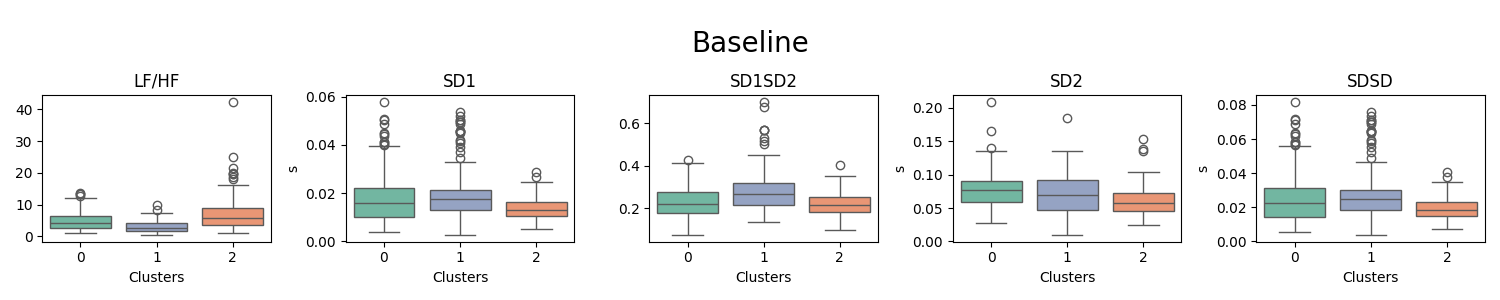

Button(button_style='success', description='Save Full Protocol Figure', style=ButtonStyle())

Button(button_style='success', description='Save Baseline Figure', style=ButtonStyle())

In [420]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
from IPython.display import display

units = dict(HR="bpm",
        RF="breaths/min",
        HF_power = "ms^2",
        LF_power = "ms^2",
        LFHF_PP_MEDIAN = "",
        SDNN = "ms",
        tot_power = "ms^2",
        VLF_power = "ms^2",
        VHF_power = "VHF Power",
        UHF_power = "ms^2",
        EI_median = "a.u.",
        ARR = "",
        PDA = "a.u.",
        beta_peak = "rad",
        SD2 = "s",
        SD1 = "s",
        mean_SCL = "normalized units",
        PC3 = "a.u.",
        PC2 = "a.u.",
        SD1SD2 = "",
        PC1 = "a.u.",
        EI_peak = "",
        LFHF_PP_MU = "",
        EI_mu = "",
        LFHF_PP_STD = "",
        SDRR = "s",
        SDSD = "s"
)

var_names = dict(HR="HR",
        RF="RF",
        HF_power = "HF Power",
        LF_power = "LF Power",
        LFHF_PP_MEDIAN = "LF/HF",
        SDNN = "SDNN",
        tot_power = "TSP",
        VHF_power = "VHF Power",
        VLF_power = "VLF Power",
        UHF_power = "UHF Power",
        EI_median = "Median E.I.",
        ARR = "ARR",
        PDA = "PDA",
        beta_peak = "\hat{\beta_{EI}}",
        SD2 = "SD2",
        SD1 = "SD1",
        mean_SCL = "SCL",
        PC3 = "PC3",
        PC2 = "PC2",
        SD1SD2 = "SD1SD2",
        PC1 = "PC1",
        EI_peak = "EI Peak",
        LFHF_PP_MU = "LF/HF (mean)",
        EI_mu = "EI",
        LFHF_PP_STD = "LF/HF (std)",
        SDRR = "SDRR",
        SDSD = "SDSD"
)

plt.close('all')
whole = False
# === CREATE INITIAL FIGURE ===
fig, ax = plt.subplots(figsize=(15, 3))


# Get all unique variables
variables = sorted(df['Variable'].unique())
num_vars = len(variables)

# === CREATE CHECKBOXES ===
checkboxes = [widgets.Checkbox(value=False, description=var) for var in variables]
for var in ["SD1", "SD2", "SD1SD2", "SDSD", "LFHF_PP_MEDIAN"]:
    checkboxes[variables.index(var)].value = True  # Pre-select some variables

# Determine layout: 2 rows, adaptive columns
num_cols = int(np.ceil(num_vars / 4))  # Split checkboxes into 4 rows
checkbox_grid = widgets.GridBox(
    checkboxes,
    layout=widgets.Layout(grid_template_columns=f"repeat({num_cols}, auto)")
)
# checkbox_container = widgets.VBox(checkboxes)  # Organize checkboxes vertically

def on_toggle(change):
    global whole, df, fig, filename, save_button
    whole = not whole
    if whole:
        df = df_whole_protocol
        fig.suptitle("Distribution of Variables by Cluster over the Whole Protocol")
        filename = "boxplot_full.svg"
    else:
        filename = "boxplot_baseline.svg"
        df = baseline_df
        fig.suptitle("Distribution of Variables by Cluster at Baseline")
    save_button.description = "Save " + ("Full Protocol" if whole else "Baseline") + " Figure"
    save_button.on_click(lambda x: fig.savefig(filename, format="svg"))
    update_plot(None)    

# === FUNCTION TO UPDATE EXISTING PLOT ===
def update_plot(_):

    selected_vars = [cb.description for cb in checkboxes if cb.value]

    fig.clear()  # Clear the existing figure instead of creating a new one
    ax.clear()  # Clear the existing figure instead of creating a new one
    
    if not selected_vars:
        ax.text(0.5, 0.5, "⚠️ No variables selected", fontsize=14, ha='center', va='center')
        fig.canvas.draw_idle()
        return

    # Define number of rows and columns for subplots
    n_cols = 5
    n_rows = int(np.ceil(len(selected_vars) / n_cols))
    fig.figzize=(n_cols*3, n_rows*3)

    for i, var in enumerate(selected_vars):
        # print(i, var)
        plt.subplot(n_rows, n_cols, i + 1)
        
        # Create boxplot
        sns.boxplot(
            data=df[df['Variable'] == var], 
            x="Cluster",
            y="Value",
            hue="Cluster",
            hue_order=[str(c) for c in cluster_labels],  
            palette=palette,
            dodge=False,
            legend=False,
            # set the plot as square
        )

        plt.title(var_names[var])
        plt.ylabel(units[var])
        plt.xlabel("Clusters")
        plt.xticks(ticks=range(len(cluster_labels)), labels=[str(c) for c in cluster_labels])
        # make the plot square

    if whole:
        fig.suptitle("Whole Protocol", y = .9, fontsize = 20, x = .5)
    else:
        fig.suptitle("Baseline", y = .9, fontsize = 20, x = .5)

    # SET THE SUPTITLE Y POSITION

    fig.tight_layout(rect=[0, 0, 1, 0.95])
    plt.draw()  # Update the figure without creating a new one

# === CREATE BUTTON TO UPDATE PLOT ===
update_button = widgets.Button(description="Update Plot", button_style='primary')
update_button.on_click(update_plot)  # Call `update_plot()` when clicked

# === DISPLAY CHECKBOXES & BUTTON ===
display(checkbox_grid, update_button)

# === INITIAL PLOT ===
update_plot(None)  # Draw the initial plot

# add a button to save the figure as svg
save_button = widgets.Button(description="Save Figure", button_style='success')
filename = "boxplot_full.svg" if whole else "boxplot_baseline.svg"
save_button.on_click(lambda x: fig.savefig(filename, format="svg"))
display(save_button)

#add a toggle to select baseline or full protocol
toggle = widgets.ToggleButton(value=False, description='Baseline', button_style='info')
display(toggle)
# on toggle, change df and update plot
toggle.observe(on_toggle, names='value')

    

# save the boxplots
%matplotlib widget
for key in F.keys():
    F[key].savefig("METRICS/" + key + '.svg', bbox_inches='tight', transparent=True)
    # set the background as transparent
    F[key].savefig("METRICS/" + key + '.png', dpi = 200, bbox_inches='tight', transparent=True)

In [426]:
from graphviz import Digraph

dot = Digraph(format="png")
dot.attr(rankdir="TB", size="10")

# Define the autoencoder layers
layers = [
    "Input (4)",
    "Dense (64)", "Dropout", 
    "Dense (32)", "Dropout",
    "Dense (16)", "Dropout",
    "ExpandDims",
    "MultiHeadAttention",
    "SqueezeDims",
    "Add",
    "LayerNorm",
    "Dense (16)", "Dropout",
    "Dense (32)", "Dropout",
    "Dense (64)", "Dropout",
    "Dense (4) (Output)"
]

# Define connections
connections = [
    ("Input (4)", "Dense (64)"), ("Dense (64)", "Dropout"),
    ("Dropout", "Dense (32)"), ("Dense (32)", "Dropout"),
    ("Dropout", "Dense (16)"), ("Dense (16)", "Dropout"),
    ("Dropout", "ExpandDims"),
    ("ExpandDims", "MultiHeadAttention"),
    ("MultiHeadAttention", "SqueezeDims"),
    ("SqueezeDims", "Add"), ("Dropout", "Add"),
    ("Add", "LayerNorm"),
    ("LayerNorm", "Dense (16)"), ("Dense (16)", "Dropout"),
    ("Dropout", "Dense (32)"), ("Dense (32)", "Dropout"),
    ("Dropout", "Dense (64)"), ("Dense (64)", "Dropout"),
    ("Dropout", "Dense (4) (Output)")
]

# Add nodes and edges
for layer in layers:
    dot.node(layer, layer, shape="box", style="filled", fillcolor="lightblue")

for start, end in connections:
    dot.edge(start, end)

# Render the file
dot.render("autoencoder_architecture", format="png", view=True)

'autoencoder_architecture.png'

In [ ]:
# PLOT THE 3D SCATTERPLOT OF THE METRICS, CLUSTERIZE METRIC BY METRIC POI BY POI

import pandas as pd
import numpy as np
import plotly.graph_objects as go
import plotly.colors as pc
from plotly.subplots import make_subplots
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler


# Select the relevant metrics
PDA = df_tables["PDA"]
SD1 = df_tables["SD1"]
LFHF = df_tables["LFHF_PP_MEDIAN"]

# List of even-indexed columns
even_columns = PDA.iloc[:, ::2].columns  

# Define grid layout (2 rows, 4 columns)
num_plots = len(even_columns)
rows = 2
cols = 4  # Adjust based on number of variables

# Create subplot figure with multiple 3D scatterplots
fig = make_subplots(
    rows=rows, cols=cols, 
    specs=[[{"type": "scatter3d"}] * cols] * rows,  # Define subplot type as 3D
    subplot_titles=[f"{var}" for var in even_columns]  # Use variable names as titles
)

colorscale = 'RdYlGn'  # Define colorscale
data = pd.DataFrame(columns = ["PDA", "SD1", "LFHF"])
data["PDA"] = PDA.iloc[:, ::2].mean(axis=1, skipna=True)
data["SD1"] = SD1.iloc[:, ::2].mean(axis=1, skipna=True)
data["LFHF"] = LFHF.iloc[:, ::2].mean(axis=1, skipna=True)
data = data.dropna()

# Standardize the data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

# Perform KMeans clustering
kmeans = KMeans(n_clusters=2, random_state=42, n_init=2)
clusters_metrics = kmeans.fit_predict(data_scaled)
clusters_metrics = pd.DataFrame(clusters_metrics, index=data.index, columns=["Cluster"])
data = pd.concat([data, clusters_metrics], axis=1)

# Map pearson_clusters to marker symbols
unique_shapes = pearson_clusters['Cluster'].unique().astype(str)
shape_map = {val: shape for val, shape in zip(unique_shapes, ["circle", "square-open", "cross", "triangle-up"])}

# Iterate through the even columns and create scatterplots
for i, var in enumerate(even_columns):
    # Determine the correct row and column for the subplot
    row = (i // cols) + 1
    col = (i % cols) + 1

    # Standardize the data
    Data = pd.concat([PDA[var], SD1[var], LFHF[var]], axis=1).dropna()
    Data.columns = ["PDA", "SD1", "LFHF"]
    Data_scaled = StandardScaler().fit_transform(Data)
    cluster_var = kmeans.fit_predict(Data_scaled)
    Data = pd.concat([Data, pd.DataFrame(cluster_var, columns=['Cluster_var'], index=Data.index)], axis=1)
    Data = pd.concat([Data, pearson_clusters.dropna().astype(str)], axis=1).dropna(subset ='Cluster')

    # Extract colors for each cluster
    num_clusters = len(Data['Cluster_var'].dropna().unique())
    cluster_colors = pc.sample_colorscale(colorscale, [i / (num_clusters - 1) for i in range(num_clusters)])

    # Assign marker symbols based on pearson_clusters
    Data["Marker"] = Data["Cluster"].map(shape_map)

    # Add scatter plot for this variable to the subplot
    scatter = go.Scatter3d(
        x=Data["PDA"], y=Data["SD1"], z=Data["LFHF"],
        mode='markers',
        marker=dict(
            size=6,
            color=Data['Cluster_var'],  
            colorscale=colorscale,  
            opacity=1,
            symbol=Data["Marker"]  # Assign different marker shapes
        ),
        text=Data.index,  
        showlegend=False  # Hide the main scatter from legend
    )
    
    fig.add_trace(scatter, row=row, col=col)  # Add scatter plot to subplot

# Add legend entries for each marker shape
for val, shape in shape_map.items():
    fig.add_trace(go.Scatter3d(
        x=[None],  # No actual data points, only used for the legend
        y=[None],
        z=[None],
        mode='markers',
        marker=dict(
            size=10,
            symbol=shape,
            color = 'black'
        ),
        name=f'Pearson Cluster {val}'
    ))
for i in range(num_clusters):
    fig.add_trace(go.Scatter3d(
        x=[None],  # No actual data points, only used for the legend
        y=[None],
        z=[None],
        mode='markers',
        marker=dict(
            size=10,
            color = cluster_colors[i]
        ),
        name=f'POI Cluster {i}'
    ))

# Define global axis limits (change these values based on your data range)
x_range = [-5, 5]  # Adjust to full dataset
y_range = [0, 0.07]
z_range = [0, 25]

# Define a common camera view (adjust values for desired rotation)
common_camera = dict(
    eye=dict(x=1.5, y=1.5, z=1.2)  # Change these values to adjust rotation
)

# Generate scene dictionary for each subplot (to sync axes & rotation)
scene_dict = {}
for i in range(1, rows * cols + 1):  # Loop over all subplots
    scene_dict[f'scene{i}'] = dict(
        xaxis_title="PDA",
        yaxis_title="SD1",
        zaxis_title="LFHF",
        xaxis=dict(range=x_range),  # Set consistent X-axis limits
        yaxis=dict(range=y_range),  # Set consistent Y-axis limits
        zaxis=dict(range=z_range),  # Set consistent Z-axis limits
        camera=common_camera  # Apply the same rotation to all subplots
    )

# Update figure layout with linked axes & rotation
fig.update_layout(
    title_text="3D Scatter Plots of PDA, SD1, LFHF (2x4 Grid)", 
    height=1000, width=1800,  # Adjust figure size to fit 2x4 grid
    margin=dict(l=0, r=0, b=0, t=50),
    **scene_dict,  # ✅ Apply settings to all subplots
)

# Show the figure
fig.show()

# Extract the mean Pearson correlation values for clustering
mae_data = subject_errors.drop('Mean', axis=1).values

# Standardize the data
scaler = StandardScaler()
mae_data_scaled = scaler.fit_transform(mae_data)

# Perform KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)  # Explicitly set n_init
clusters = kmeans.fit_predict(mae_data_scaled)

# Add the cluster labels to the dataframe
subject_errors['Cluster'] = clusters

# Define the colorscale to match the scatter plot
colorscale = 'Plasma'

# Create the figure and add the main scatter plot (hidden from legend)
fig = go.Figure(
    data=[go.Scatter3d(
        x=subject_errors[vars_to_use[0]],
        y=subject_errors[vars_to_use[1]],
        z=subject_errors[vars_to_use[2]],
        mode='markers',
        marker=dict(
            size=10,
            color=subject_errors['Cluster'],  # Use cluster labels for color
            colorscale=colorscale,  # Ensure consistency
            opacity=1
        ), 
        text=subject_errors.index,  # Display Bicocca ID on hover
        showlegend=False  # Hide this trace from the legend
    )]
)

# Extract correct colors from the colorscale
num_clusters = len(subject_errors['Cluster'].unique())
cluster_colors = pc.sample_colorscale(colorscale, [i / (num_clusters - 1) for i in range(num_clusters)])

# Add separate traces for each cluster (these will be in the legend)
for i, cluster in enumerate(sorted(subject_errors['Cluster'].unique())):
    fig.add_trace(go.Scatter3d(
        x=[None],  # No actual data points, only used for the legend
        y=[None],
        z=[None],
        mode='markers',
        marker=dict(
            size=10,
            color=cluster_colors[i]  # Use sampled color from the colormap
        ),
        name=f'Cluster {cluster}'
    ))

# Set axis labels
fig.update_layout(
    scene=dict(
        xaxis_title=vars_to_use[0],
        yaxis_title=vars_to_use[1],
        zaxis_title=vars_to_use[2]
    ),
    title='3D Scatter Plot of Mean Absolute Error Values',
    width=1000,  # Increase figure width
    height=900,  # Increase figure height
    margin=dict(l=0, r=0, b=0, t=50),  # Reduce margins to prevent cropping
    scene_camera=dict(eye=dict(x=1.5, y=1.5, z=1.2))  # Adjust the 3D perspective
)

# Show the plot
fig.show()

In [422]:
# draw a diagram of the network architecture
from tensorflow.keras.utils import plot_model  # type: ignore

# represent the architecture of the autoencoder; use a horizontal layout for the chart
plot_model(
    autoencoder,
    to_file='autoencoder_model.png',  # Output file name
    show_shapes=True,                         # Show tensor shapes
    show_layer_names=True,                    # Show layer names
    # dpi=300,                                  # High resolution
    # rankdir='`',                             # Left-to-right flow
    expand_nested=False,                       # Show nested structures if applicable
    show_layer_activations = True             # Show layer activations
)

autoencoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 4)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │        320 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 64)        │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 32)        │      2,080 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 32)        │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 16)        │        528 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 16)        │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expand_dims_layer   │ (None, 1, 16)     │          0 │ dropout_2[0][0]   │
│ (ExpandDimsLayer)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 1, 16)     │      4,304 │ expand_dims_laye… │
│ (MultiHeadAttentio… │                   │            │ expand_dims_laye… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ squeeze_dims_layer  │ (None, 16)        │          0 │ multi_head_atten… │
│ (SqueezeDimsLayer)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 16)        │          0 │ squeeze_dims_lay… │
│                     │                   │            │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 16)        │         32 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 16)        │        272 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 16)        │          0 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 32)        │        544 │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 32)        │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 64)        │      2,112 │ dropout_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 64)        │          0 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 4)         │        260 │ dropout_6[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 10,452 (40.83 KB)

 Trainable params: 10,452 (40.83 KB)

 Non-trainable params: 0 (0.00 B)

# PHASES 
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
# append 'Phase' to vars_to_use
v = vars_to_use.tolist()  # Convert Index to list
v.append('Phase')  # Append 'Phase'
v = pd.Index(v)  # Convert list back to Index
plt.close('all')
label_names = ['Baseline',
               'Baseline -> Cafe',
                'Cafe',
                'Cafe -> Square',
                'Square',
                'Square -> Crosswalk',
                'Crosswalk',
                'Crosswalk -> U3',
                'U3',
                'U3 -> Trivulziana',
                'Trivulziana',
                'Trivulziana -> U4',
                'U4',
                'U4 -> Tram',
                'Tram']
for subject_id, df in data_tot.items():
    subject_id = 'Bicocca' + subject_id
    # if df is empty, skip
    if df.empty:
        continue
    if subject_id in timestamps_df.index:
        for phase in range(8):
            start_col = f'{phase}_start'
            end_col = f'{phase}_end'
            if start_col in timestamps_df.columns and end_col in timestamps_df.columns:
                start_time = timestamps_df.loc[subject_id, start_col]
                end_time = timestamps_df.loc[subject_id, end_col]
                if pd.notna(start_time) and pd.notna(end_time):
                    df.loc[(df['Timestamp'] >= start_time) & (df['Timestamp'] <= end_time), 'Phase'] = phase
                    if phase < 7:
                        next_start_col = f'{phase + 1}_start'
                        next_start_time = timestamps_df.loc[subject_id, next_start_col]
                        if pd.notna(next_start_time):
                            df.loc[(df['Timestamp'] > end_time) & (df['Timestamp'] < next_start_time), 'Phase'] = phase + 0.5


# 2D LATENT SPACE VISUALIZATION
# 
# # --- Latent Space Visualization ---
# Step 1: Extract the latent space
# id = '03'
for id in data_tot.keys():
    # try:
        encoder = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer(index=-2).output)
        random_subject_data = data_tot[id]

        if resample > 0:
            phases = random_subject_data.set_index('Timestamp').resample(str(resample) + 's').asfreq()['Phase'].bfill()
            random_subject_data = random_subject_data.resample(str(resample) + 's', on='Timestamp').mean(numeric_only=True).reset_index()
        else:
            phases = random_subject_data['Phase']
        t = random_subject_data['Timestamp']
        
        random_subject_data = random_subject_data[vars_to_use]
        if rolling_window_size > 1:
            random_subject_data = random_subject_data.rolling(window=rolling_window_size, min_periods=1).mean(numeric_only=True)
        # random_subject_data = random_subject_data[vars_to_use.append( 'Phase')]
        # in random_subject_data, only keep the variables in vars_to_use and the variable 'Phase'
        
        if unwrap:
            beta_columns = [col for col in random_subject_data.columns if 'beta' in col.lower()]
            for beta_col in beta_columns:
                random_subject_data[beta_col] = np.unwrap(random_subject_data[beta_col])
        if scaler != 'None':
            random_subject_data = pd.DataFrame(scaler.transform(random_subject_data), columns= vars_to_use)
            
        latent_representations = encoder.predict(random_subject_data)

        # Step 2: Reduce dimensions to 2 using PCA or t-SNE
        use_tsne = True  # Change to False to use PCA instead
        ### PROVA CON PCA ###
        if use_tsne:
            tsne = TSNE(n_components=2, random_state=42)
            latent_2d = tsne.fit_transform(latent_representations)
        else:
            pca = PCA(n_components=2)
            latent_2d = pca.fit_transform(latent_representations)

        # Step 3: Prepare labels and colormap
        unique_phases = phases.unique()
        label_names = unique_phases
        n_labels = len(label_names)

        # Map phases to integers for coloring
        phase_to_int = {phase: i for i, phase in enumerate(label_names)}
        phase_colors = phases.map(phase_to_int)

        # Generate discrete colors from the HSV palette
        hsv = plt.get_cmap('jet', n_labels)  # Sample from HSV colormap
        colors = [hsv(i) for i in range(n_labels)]  # Create a list of discrete colors
        cmap = ListedColormap(colors)

        # Define discrete boundaries
        levels = np.arange(n_labels + 1)
        norm = BoundaryNorm(levels, ncolors=n_labels)

        # Step 4: Plot the latent space
        fig = plt.figure(figsize=(10, 8))
        scatter = plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=phase_colors, cmap=cmap, norm=norm)
        label_names = label_names.astype(str)
        # in label_names, change the .5 values to previous phase -> next phase number (ex 1.5 is 1 -> 2)
        # foe ach elem,ent of label_names, if it contains a .5, replace it with previous phase -> next phase
        # for i in range(len(label_names)):
        #     if '.5' in label_names[i]:
        #         label_names[i] = 'W' + label_names[i-1]


        # Add a colorbar with labels
        cbar = plt.colorbar(scatter, boundaries=levels, ticks=np.arange(n_labels))
        cbar.set_ticklabels(label_names)  # Set custom labels for phases
        cbar.set_label('Phase')

        # Final plot details
        plt.title(f'Bicocca{id} - Latent Space Visualization')
        plt.xlabel('Dimension 1')
        plt.ylabel('Dimension 2')
        plt.show()
        # print(id)
        # break
    # except:
    #     continue
# make the plot's background transparent
# fig.savefig('latent_space.svg', transparent=True)

# 3D LATENT SPACE VISUALIZATION

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from tensorflow.keras.models import Model # type: ignore
from matplotlib.colors import ListedColormap, BoundaryNorm
from mpl_toolkits.mplot3d import Axes3D  # 3D plotting support
%matplotlib widget
# --- Latent Space Visualization ---
# Step 1: Extract the latent space
for id in data_tot.keys():
    encoder = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer(index=-2).output)
    random_subject_data = data_tot[id]

    if resample > 0:
        phases = random_subject_data.set_index('Timestamp').resample(str(resample) + 's').asfreq()['Phase'].bfill()
        random_subject_data = random_subject_data.resample(str(resample) + 's', on='Timestamp').mean(numeric_only=True).reset_index()
    else:
        phases = random_subject_data['Phase']
    
    t = random_subject_data['Timestamp']
    random_subject_data = random_subject_data[vars_to_use]
    
    if rolling_window_size > 1:
        random_subject_data = random_subject_data.rolling(window=rolling_window_size, min_periods=1).mean(numeric_only=True)
    
    if unwrap:
        beta_columns = [col for col in random_subject_data.columns if 'beta' in col.lower()]
        for beta_col in beta_columns:
            random_subject_data[beta_col] = np.unwrap(random_subject_data[beta_col])

    if scaler != 'None':
        random_subject_data = pd.DataFrame(scaler.transform(random_subject_data), columns=vars_to_use)
    
    # Extract latent representations
    latent_representations = encoder.predict(random_subject_data)

    # Step 2: Reduce dimensions to 3D using PCA or t-SNE
    use_tsne = True  # Change to False to use PCA instead
    if use_tsne:
        tsne = TSNE(n_components=3, random_state=42)
        latent_3d = tsne.fit_transform(latent_representations)
    else:
        pca = PCA(n_components=3)
        latent_3d = pca.fit_transform(latent_representations)

    # Step 3: Prepare labels and colormap
    unique_phases = phases.unique()
    label_names = unique_phases
    n_labels = len(label_names)

    # Map phases to integers for coloring
    phase_to_int = {phase: i for i, phase in enumerate(label_names)}
    phase_colors = phases.map(phase_to_int)

    # Generate discrete colors from colormap
    hsv = plt.get_cmap('jet', n_labels)  
    colors = [hsv(i) for i in range(n_labels)]  
    cmap = ListedColormap(colors)
    
    # Define discrete boundaries
    levels = np.arange(n_labels + 1)
    norm = BoundaryNorm(levels, ncolors=n_labels)

    # Step 4: Create 3D plot
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d', facecolor='none')  # 3D scatter plot with transparent background

    # Scatter plot in 3D
    scatter = ax.scatter(latent_3d[:, 0], latent_3d[:, 1], latent_3d[:, 2], 
                         c=phase_colors, cmap=cmap, norm=norm, alpha=0.8, s=15)

    # Labels & View Angle
    ax.set_xlabel('Dimension 1')
    ax.set_ylabel('Dimension 2')
    ax.set_zlabel('Dimension 3')
    ax.set_title(f'Bicocca{id} - 3D Latent Space Visualization')
    ax.view_init(elev=20, azim=45)  # Adjust viewing angle

    # Add a colorbar with labels
    cbar = plt.colorbar(scatter, boundaries=levels, ticks=np.arange(n_labels))
    cbar.set_ticklabels(label_names.astype(str))  
    cbar.set_label('Phase')

    # Show plot
    plt.show()


# MODEL # 1 - AUTOENCODER WITH DROPOUT, OPTIONAL ATTENTION, AND L2 REGULARIZATION

# the dataset is composed of data from different subjects. use each subject as a batch. 
# The batch size is the number of samples in each batch.


cleanup()

by_segment = True
attention = True
rolling_window_size = 15
resample = 1
neurons = 64
l2_regularization = 0.0
dropout_factor = 0.1

# Load your normalized DataFrame
data = df_tot.resample(str(resample) + 's', on='Timestamp').mean(numeric_only=True).reset_index()
data = data[vars_to_use].dropna()  # Assuming the data is already normalized
data = data.values  # Convert DataFrame to numpy array

# Scale the data
scaler = MinMaxScaler()
scaler = scaler.fit(data)
data_scaled = scaler.fit_transform(data)

# Define input dimensions
input_dim = data_scaled.shape[1]  # Number of features (10 variables)

# Define the encoder with L2 regularization and Dropout
encoder_input = tf.keras.layers.Input(shape=(input_dim,))
x = tf.keras.layers.Dense(neurons*4, activation='relu', kernel_regularizer=regularizers.l2(l2_regularization))(encoder_input)
x = Dropout(dropout_factor)(x)
x = tf.keras.layers.Dense(neurons*2, activation='relu', kernel_regularizer=regularizers.l2(l2_regularization))(x)
x = Dropout(dropout_factor)(x)

if attention:
    # Custom layer to expand dimensions
    class ExpandDimsLayer(tf.keras.layers.Layer):
        def __init__(self, axis, **kwargs):
            super(ExpandDimsLayer, self).__init__(**kwargs)
            self.axis = axis

        def call(self, inputs):
            return tf.expand_dims(inputs, axis=self.axis)

    # Custom layer to squeeze dimensions
    class SqueezeDimsLayer(tf.keras.layers.Layer):
        def __init__(self, axis, **kwargs):
            super(SqueezeDimsLayer, self).__init__(**kwargs)
            self.axis = axis

        def call(self, inputs):
            return tf.squeeze(inputs, axis=self.axis)

    # Expand dimensions to add sequence length dimension
    x_expanded = ExpandDimsLayer(axis=1)(x)
    
    # Attention layer
    attention_output = MultiHeadAttention(num_heads=4, key_dim=neurons)(x_expanded, x_expanded)
    attention_output = SqueezeDimsLayer(axis=1)(attention_output)  # Remove the sequence length dimension
    x = LayerNormalization()(attention_output + x)  # Residual connection and normalization

    x = Dense(neurons, activation='relu')(x)
    x = Dropout(dropout_factor)(x)


encoder_output = tf.keras.layers.Dense(neurons, activation='relu', kernel_regularizer=regularizers.l2(l2_regularization))(x)
encoder = tf.keras.Model(encoder_input, encoder_output, name="encoder")

# Define the decoder
decoder_input = tf.keras.layers.Input(shape=(neurons,))
x = tf.keras.layers.Dense(neurons*2, activation='relu', kernel_regularizer=regularizers.l2(l2_regularization))(decoder_input)
x = Dropout(dropout_factor)(x)
x = tf.keras.layers.Dense(neurons*4, activation='relu', kernel_regularizer=regularizers.l2(l2_regularization))(x)
x = Dropout(dropout_factor)(x)
decoder_output = tf.keras.layers.Dense(input_dim, activation='sigmoid', kernel_regularizer=regularizers.l2(l2_regularization))(x)
decoder = tf.keras.Model(decoder_input, decoder_output, name="decoder")

# Define the autoencoder
autoencoder_input = encoder_input
autoencoder_output = decoder(encoder_output)

# Implement EarlyStopping and ReduceLROnPlateau
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)

optimizers = {
    'SGD': tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9),
    'RMSprop': tf.keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9),
    'Adagrad': tf.keras.optimizers.Adagrad(learning_rate=0.01),
    'Adadelta': tf.keras.optimizers.Adadelta(learning_rate=1.0, rho=0.95),
    'Nadam': tf.keras.optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999), 
    'Adam': tf.keras.optimizers.Adam(learning_rate=0.001)
}

tot_segments = 0
for batch in segment_data_generator(data_tot, 
                            phase_timestamps=timestamps, 
                            rolling_window_size=rolling_window_size, 
                            vars_to_use=vars_to_use, 
                            scaler=scaler, 
                            resample=resample):
    tot_segments += 1

del batch

# optimizerzs = {'Adam': tf.keras.optimizers.Adam(learning_rate=0.001)}
with tf.device('/GPU:0'):
    for optimizer in optimizers.keys():
    # Choose an optimizer
        print(f"Memory usage: {memory_usage():.2f} MB")
        chosen_optimizer = optimizers[optimizer]
        print("USING OPTIMIZER", optimizer)
        autoencoder = tf.keras.Model(autoencoder_input, autoencoder_output, name="autoencoder")

        autoencoder.compile(optimizer=chosen_optimizer, loss='mae', metrics = ['mse', 'mae'])
        autoencoder.summary()

        if by_segment:
            # Each batch is a single procotol segment from a single subject
            generator = segment_data_generator( data_tot, 
                                                phase_timestamps=timestamps, 
                                                rolling_window_size=rolling_window_size, 
                                                vars_to_use=vars_to_use, 
                                                scaler=scaler, 
                                                resample=resample)
            # the steps per epoch is the number of batches
            steps_per_epoch = tot_segments
        else:
            # Each batch is a whole protocol recording from a single subject
            generator = subject_data_generator( data_tot, 
                                                rolling_window_size = rolling_window_size, 
                                                vars_to_use = vars_to_use, 
                                                scaler = scaler, 
                                                resample = resample)
            steps_per_epoch = len(data_tot)
        
        name = "encoder_model_1" + optimizer + ("_attention" if attention else "") + ("_by_subject" if not by_segment else "_by_segment") + ("_l2reg_" + str(l2_regularization) if l2_regularization > 0 else "") + ("_dropout_" + str(dropout_factor) if dropout_factor > 0 else "")

        history = autoencoder.fit(  generator, 
                                    steps_per_epoch=steps_per_epoch, 
                                    epochs=25,
                                    verbose=1,
                                    shuffle=False, 
                                    callbacks=[early_stopping, lr_scheduler])
        if by_segment:
            # Each batch is a single procotol segment from a single subject
            generator = segment_data_generator( data_tot, 
                                                phase_timestamps=timestamps, 
                                                rolling_window_size=rolling_window_size, 
                                                vars_to_use=vars_to_use, 
                                                scaler=scaler, 
                                                resample=resample)
            # the steps per epoch is the number of batches
            steps_per_epoch = tot_segments
        else:
            # Each batch is a whole protocol recording from a single subject
            generator = subject_data_generator( data_tot, 
                                                rolling_window_size = rolling_window_size, 
                                                vars_to_use = vars_to_use, 
                                                scaler = scaler, 
                                                resample = resample)
            steps_per_epoch = len(data_tot)
        # SHAP(autoencoder, generator, name, vars_to_use)
        randomSubjectEvaluation(autoencoder, 
                                optimizer, 
                                name)
                            
        os.makedirs('MODELS', exist_ok=True)
        autoencoder.save('MODELS/' + name + ".keras")
        
        print(f"Memory usage: {memory_usage():.2f} MB")


# MODEL # 2 - AUTOENCODER WITH DROPOUT - SUBJECTS AS BATCHES
# use each subject's data as a batch
# try smoothing the data with a rolling window of n seconds, and downsampling
# try using different alternative optmizers
%%capture
resample = 5
df = df_tot.resample(str(resample) + 's', on='Timestamp').mean(numeric_only=True).reset_index()
df = df[vars_to_use].dropna()  # Assuming the data is already normalized
data = df.values  # Convert DataFrame to numpy array
scaler = MinMaxScaler()
scaler = scaler.fit(data)

neurons = 16
dropout_factor = 0.1


# Alternative optimizers
optimizers = {
    'SGD': tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9),
    'RMSprop': tf.keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9),
    'Adagrad': tf.keras.optimizers.Adagrad(learning_rate=0.01),
    'Adadelta': tf.keras.optimizers.Adadelta(learning_rate=1.0, rho=0.95),
    'Nadam': tf.keras.optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999),
    'Adam': tf.keras.optimizers.Adam(learning_rate=0.001)
}


for optimizer in optimizers.keys():
# Choose an optimizer
    chosen_optimizer = optimizers[optimizer]
    print("USING OPTIMIZER ", optimizer)
    autoencoder = Sequential([
    Dense(neurons * 4, activation='relu', input_shape=(len(vars_to_use),)),
    Dropout(dropout_factor),
    Dense(neurons * 2, activation='relu'),
    Dropout(dropout_factor),
    Dense(neurons, activation='relu'),
    Dropout(dropout_factor),
    Dense(len(vars_to_use), activation='sigmoid')  # Same output shape as input
    ])
    # Choose an optimizer

    autoencoder.compile(optimizer=chosen_optimizer, loss='mae')
    
    generator = subject_data_generator(data_tot, vars_to_use=vars_to_use, scaler=scaler, resample = resample)
    # Use the generator during training
    autoencoder.fit(generator, steps_per_epoch=len(data_tot), epochs=50, verbose=1)
    name = "encoder_model_2" + optimizer
    # reconstruction(autoencoder, data, vars_to_use, scaler='none')
    randomSubjectEvaluation(autoencoder, 
                            optimizer = optimizer, 
                            filename = name)
    os.makedirs('MODELS', exist_ok=True)
    autoencoder.save('MODELS/' + name + ".keras")
        
    
            # Each batch is a whole protocol recording from a single subject
    generator = subject_data_generator( data_tot, 
                                        rolling_window_size = rolling_window_size, 
                                        vars_to_use = vars_to_use, 
                                        scaler = scaler, 
                                        resample = resample)
    steps_per_epoch = len(data_tot)
    # SHAP(autoencoder, generator, name, vars_to_use)
    
    